# **Análisis de los datos de PM10 y PM 2.5**

## **Carga de datos**

En la parte superior cargaremos los paquetes

In [31]:
# Cargar paquetes
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Pruebas estadísticas
from scipy.stats import ks_1samp, shapiro, norm
from scipy.stats import kruskal
import scikit_posthocs as sp
from scipy.stats import spearmanr
from scipy.stats import mannwhitneyu

import warnings

* Carguemos los datos recopilados para realizar los análisis

In [3]:
# Cargar los datos
datos_recopilados = pd.read_excel('C:/Users/cdeor/OneDrive/Documentos/Python/jb_aet_pm10_25/docs/_data/data_1.xlsx')

# Renombrar las columnas
datos_recopilados.rename(columns={
    'Estacion': 'Estacion',
    'Fecha inicial': 'Fecha',
    'PARÁMETRO': 'Parametro',
    'CONCENTRACIÓN mg/m3': 'Concentración_mg/m3'
}, inplace=True)

datos_recopilados.head(5)

,Estacion,Fecha,Parametro,Concentración_mg/m3
0,LA GLORIA,2022-12-21 00:00:00,PM 10,40.69
1,LA GLORIA,2022-12-20 00:00:00,PM 10,41.01
2,LA GLORIA,2022-12-19 00:00:00,PM 10,40.94
3,LA GLORIA,2022-12-18,PM 10,39.87
4,LA GLORIA,2022-12-17,PM 10,38.79


* Ajustemos la fecha como `datetime`:

In [4]:
# Convertir la columna "Fecha" a formato datetime
datos_recopilados['Fecha'] = pd.to_datetime(datos_recopilados['Fecha'], dayfirst=True)

# Mostrar los datos para verificar
datos_recopilados.head(5)

,Estacion,Fecha,Parametro,Concentración_mg/m3
0,LA GLORIA,2022-12-21,PM 10,40.69
1,LA GLORIA,2022-12-20,PM 10,41.01
2,LA GLORIA,2022-12-19,PM 10,40.94
3,LA GLORIA,2022-12-18,PM 10,39.87
4,LA GLORIA,2022-12-17,PM 10,38.79


* Información de los datos de recopilación

In [5]:
datos_recopilados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1352 entries, 0 to 1351
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Estacion             1352 non-null   object        
 1   Fecha                1352 non-null   datetime64[ns]
 2   Parametro            1352 non-null   object        
 3   Concentración_mg/m3  1352 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 42.4+ KB


* Carguemos los datos de parámetros

In [6]:
# Cargar los datos
datos_parametros = pd.read_excel('C:/Users/cdeor/OneDrive/Documentos/Python/jb_aet_pm10_25/docs/_data/parametros.xlsx')

# Eliminar las columnas especificadas
datos_parametros = datos_parametros.drop(columns=['Unnamed: 1', 'Unnamed: 3'])

# Renombrar las columnas
datos_parametros.rename(columns={
    'FECHA ': 'Fecha',
    'VALOR': 'Valor',
    'UNIDAD': 'Unidad',
    'PARAMETRO': 'Parametros_climaticos'
}, inplace=True)

# Convertir la columna "Fecha" a formato datetime
datos_parametros['Fecha'] = pd.to_datetime(datos_parametros['Fecha'], format='%Y-%m-%d %H:%M', errors='coerce')

datos_parametros.head()

,Fecha,Valor,Unidad,Parametros_climaticos
0,2020-06-17,249.907970,Grados (°),Dirección Viento
1,2020-06-18,106.967656,Grados (°),Dirección Viento
2,2020-06-19,352.443983,Grados (°),Dirección Viento
3,2020-06-20,161.221664,Grados (°),Dirección Viento
4,2020-06-21,192.649780,Grados (°),Dirección Viento


* Información de los datos de parámetros

In [7]:
datos_parametros.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Fecha                  5171 non-null   datetime64[ns]
 1   Valor                  5171 non-null   float64       
 2   Unidad                 5171 non-null   object        
 3   Parametros_climaticos  5171 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 161.7+ KB


## **Análisis de la variable fecha**

* Realicemos un análisis univariado

In [8]:
fecha_info = pd.DataFrame({
    'Primer Fecha': [datos_recopilados['Fecha'].min()],
    'Última Fecha': [datos_recopilados['Fecha'].max()]
})

fecha_info

,Primer Fecha,Última Fecha
0,2020-09-01,2023-12-21


:::{admonition} **Conclusión sobre el rango de fechas**
:class: tip

1. **Rango temporal**:
   - La variable `Fecha` cubre un período desde el **1 de septiembre de 2020** hasta el **21 de diciembre de 2023**.
   - Este rango abarca aproximadamente **3 años y 3 meses**, lo que sugiere una recolección de datos a lo largo de un periodo considerable.

2. **Consistencia temporal**:
   - El amplio rango sugiere que el sistema de monitoreo ha estado activo durante un tiempo prolongado.
   - Sin embargo, será importante verificar si hay gaps significativos dentro de este rango, lo que podría afectar el análisis de tendencias o patrones temporales.

:::

## **Análisis de la variable estación**

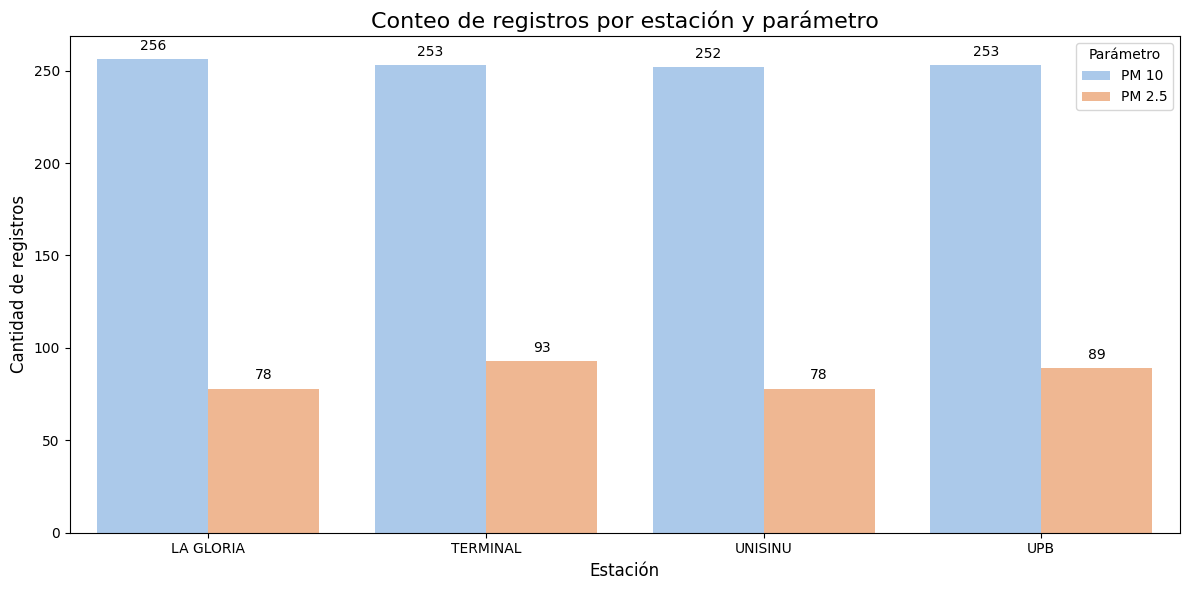

In [12]:
# Suprimir advertencias
warnings.filterwarnings("ignore", category=FutureWarning)

# Crear un resumen con conteo para PM 10 y PM 2.5
conteo_parametros = (
    datos_recopilados.groupby(['Estacion', 'Parametro']).size().unstack(fill_value=0)
    .reset_index()
)

# Calcular el porcentaje
conteo_parametros['Total'] = conteo_parametros['PM 10'] + conteo_parametros['PM 2.5']
conteo_parametros['PM 10 %'] = (conteo_parametros['PM 10'] / conteo_parametros['Total'] * 100).round(2)
conteo_parametros['PM 2.5 %'] = (conteo_parametros['PM 2.5'] / conteo_parametros['Total'] * 100).round(2)

# Derretir los datos para el gráfico
conteo_parametros_melted = conteo_parametros.melt(
    id_vars='Estacion', 
    value_vars=['PM 10', 'PM 2.5'], 
    var_name='Parametro', 
    value_name='Cantidad'
)

# Gráfico de barras
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=conteo_parametros_melted, x='Estacion', y='Cantidad', hue='Parametro', palette='pastel')

# Agregar los valores en las barras
for bar, cantidad in zip(ax.patches, conteo_parametros_melted['Cantidad']):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    ax.text(x, y + 5, f'{cantidad:.0f}', ha='center', fontsize=10)

# Configurar etiquetas y título
plt.title('Conteo de registros por estación y parámetro', fontsize=16)
plt.xlabel('Estación', fontsize=12)
plt.ylabel('Cantidad de registros', fontsize=12)
plt.legend(title='Parámetro')

# Mostrar el gráfico
plt.tight_layout()
plt.show()


:::{admonition} ****Interpretación de la gráfica: Conteo de registros por estación y parámetro****
:class: tip

La gráfica muestra la distribución de registros disponibles para los parámetros **PM 10** y **PM 2.5** en las cuatro estaciones: **LA GLORIA**, **TERMINAL**, **UNISINU** y **UPB**.

1. **Registros de PM 10**
    - **Cantidad predominante**:
        - En todas las estaciones, el parámetro **PM 10** tiene significativamente más registros que **PM 2.5**.
    - Cantidades específicas por estación:
        - **LA GLORIA**: 256 registros.
        - **TERMINAL**: 253 registros.
        - **UNISINU**: 252 registros.
        - **UPB**: 253 registros.
    - **Consistencia entre estaciones**:
        - Los registros de PM 10 están uniformemente distribuidos entre las estaciones, con ligeras variaciones.

2. **Registros de PM 2.5**
    - **Cantidad baja**:
        - El parámetro **PM 2.5** tiene una cantidad mucho menor de registros en comparación con **PM 10**.
    - Cantidades específicas por estación:
        - **LA GLORIA**: 78 registros.
        - **TERMINAL**: 93 registros.
        - **UNISINU**: 78 registros.
        - **UPB**: 89 registros.
    - **Variabilidad entre estaciones**:
        - Se observa mayor variación en los registros de PM 2.5 entre estaciones, siendo **TERMINAL** la que tiene más registros y **LA GLORIA** y **UNISINU** las que tienen menos.

**Conclusiones**

1. **Desbalance entre parámetros**:
   - Existe un desbalance significativo en la cantidad de datos recolectados para **PM 10** y **PM 2.5**, lo que puede limitar el análisis de este último parámetro.

2. **Consistencia en PM 10**:
   - Los registros de PM 10 son bastante consistentes entre las estaciones, lo que sugiere un mejor monitoreo de este parámetro.

3. **Datos insuficientes para PM 2.5**:
   - La baja cantidad de registros para PM 2.5 podría afectar la capacidad de realizar análisis representativos o comparaciones significativas entre estaciones.
:::

## **Análisis de las variables climaticas**

In [13]:
# Eliminar duplicados por 'Fecha' y 'Parametros_climaticos'
df_parametros_unique = datos_parametros.drop_duplicates(subset=['Fecha', 'Parametros_climaticos'])

# Generar la tabla resumen por 'Parametros_climaticos' después de eliminar duplicados
resumen_parametros_unique = df_parametros_unique.groupby('Parametros_climaticos')['Valor'].agg(
    n='count',
    media='mean',
    desviacion_estandar='std',
    mediana='median',
    min='min',
    max='max',
    Q1=lambda x: x.quantile(0.25),
    Q3=lambda x: x.quantile(0.75)
).reset_index()

resumen_parametros_unique

,Parametros_climaticos,n,media,desviacion_estandar,mediana,min,max,Q1,Q3
0,Dirección Viento,620,249.373382,74.231481,263.534591,3.062100,360.000000,230.389556,291.298178
1,Humedad,1267,96.496448,4.180253,98.000000,76.000000,107.000000,94.000000,100.000000
2,Temp. Maxima,1274,33.977539,1.981477,34.300000,26.300000,38.800000,32.800000,35.300000
3,Temp. Mínima,1266,23.964479,1.182211,24.000000,19.700000,30.796568,23.200000,24.700000
4,Velocidad Viento,744,1.682666,1.380230,1.419180,0.190966,21.692811,1.229207,1.708611


:::{admonition} **Interpretación de la tabla: Resumen por Parámetros Climáticos**
:class: tip

La tabla proporciona un análisis descriptivo para diferentes parámetros climáticos, basado en el número de registros (n), media, desviación estándar, mediana, valores mínimo y máximo, y los cuartiles Q1 y Q3.

1. **Dirección del Viento**
    - **Cantidad de datos (n)**: 620 registros disponibles.
    - **Media y mediana**:
        - La media es **249.37°**, cercana a la mediana de **263.53°**, lo que indica una distribución aproximadamente simétrica.
    - **Variabilidad**:
        - Una desviación estándar de **74.23°** sugiere una alta variabilidad en las direcciones del viento.
    - **Rango y cuartiles**:
        - Los valores oscilan entre **3.06°** y **360.00°**, con el 50% de los valores entre **230.39°** (Q1) y **291.30°** (Q3).

2. **Humedad**
    - **Cantidad de datos (n)**: 1267 registros.
    - **Media y mediana**:
        - Una media de **96.50%** y una mediana de **98%**, lo que refleja niveles de humedad consistentemente altos.
    - **Variabilidad**:
        - La desviación estándar es baja (**4.18%**), lo que indica que la humedad es bastante estable.
    - **Rango y cuartiles**:
        - Los valores están entre **76%** y **107%**, con el 50% de los datos entre **94%** (Q1) y **100%** (Q3).

3. **Temperatura Máxima**
    - **Cantidad de datos (n)**: 1274 registros.
    - **Media y mediana**:
        - La media es **33.98°C**, mientras que la mediana es ligeramente superior (**34.30°C**), sugiriendo una ligera asimetría hacia valores más bajos.
    - **Variabilidad**:
        - Una desviación estándar de **1.98°C** indica que las temperaturas máximas son relativamente consistentes.
    - **Rango y cuartiles**:
        - Los valores oscilan entre **26.30°C** y **38.80°C**, con el 50% de los datos entre **32.80°C** (Q1) y **35.30°C** (Q3).

4. **Temperatura Mínima**
    - **Cantidad de datos (n)**: 1266 registros.
    - **Media y mediana**:
        - La media es **23.96°C**, y la mediana es similar (**24.00°C**), indicando una distribución simétrica.
    - **Variabilidad**:
        - Una desviación estándar de **1.18°C** muestra una baja variabilidad en las temperaturas mínimas.
    - **Rango y cuartiles**:
        - Los valores oscilan entre **19.70°C** y **30.80°C**, con el 50% de los datos entre **23.20°C** (Q1) y **24.70°C** (Q3).

5. **Velocidad del Viento**
    - **Cantidad de datos (n)**: 744 registros.
    - **Media y mediana**:
        - La media es **1.68 m/s**, mientras que la mediana es **1.42 m/s**, lo que indica una ligera asimetría hacia valores más altos.
    - **Variabilidad**:
        - La desviación estándar es alta (**1.38 m/s**), lo que sugiere variaciones significativas en las velocidades del viento.
    - **Rango y cuartiles**:
        - Los valores van desde **0.19 m/s** hasta **21.69 m/s**, con el 50% de los datos entre **1.23 m/s** (Q1) y **1.71 m/s** (Q3).

**Conclusiones generales**

1. **Estabilidad en algunos parámetros**:
   - La **humedad** y las **temperaturas mínimas y máximas** muestran baja variabilidad, lo que refleja condiciones climáticas consistentes.

2. **Alta variabilidad en otros parámetros**:
   - La **dirección del viento** y la **velocidad del viento** presentan una mayor variabilidad, lo que podría estar relacionado con fenómenos meteorológicos locales o estacionales.

3. **Importancia del rango intercuartil (IQR)**:
   - El rango intercuartil (Q3 - Q1) es particularmente útil para identificar la dispersión central de los datos, lo que puede ayudar a detectar valores atípicos.

4. **Recomendaciones para análisis futuros**:
   - Explorar la estacionalidad en los parámetros con alta variabilidad (e.g., viento).
   - Evaluar correlaciones entre estos parámetros para identificar patrones climáticos más complejos.

:::

## **Análisis del PM 10**

### **Datos faltantes para el PM 10**

In [37]:
df_pm_10 = datos_recopilados[datos_recopilados['Parametro']=='PM 10']
df_pm_10 = df_pm_10.drop_duplicates(subset=['Fecha','Estacion'], keep='first')

df_pm_10.head()

,Estacion,Fecha,Parametro,Concentración_mg/m3
0,LA GLORIA,2022-12-21,PM 10,40.69
1,LA GLORIA,2022-12-20,PM 10,41.01
2,LA GLORIA,2022-12-19,PM 10,40.94
3,LA GLORIA,2022-12-18,PM 10,39.87
4,LA GLORIA,2022-12-17,PM 10,38.79


* Veamos la fecha de inicio y final de la toma de los datos

In [38]:
# Crear un nuevo índice con todas las fechas del mes de septiembre de 2020
fecha_inicio = df_pm_10['Fecha'].min()
fecha_fin = df_pm_10['Fecha'].max()

print(' Fecha de inicio', fecha_inicio)
print(' Fecha de final', fecha_fin)

 Fecha de inicio 2020-09-01 00:00:00
 Fecha de final 2023-12-21 00:00:00


* Ingreso de las fechas faltantes del PM 10

In [39]:
# Crear un índice de fechas continuo
nuevo_indice = pd.date_range(start=fecha_inicio, end=fecha_fin)

# Crear un DataFrame vacío para almacenar los resultados
df_res_pm10 = pd.DataFrame()

# Reindexar por cada estación
for estacion, grupo in df_pm_10.groupby('Estacion'):
    # Reindexar el grupo utilizando el rango de fechas
    grupo_reindexado = (
        grupo.set_index('Fecha')
        .reindex(nuevo_indice)
        .reset_index()
    )
    # Asignar el nombre de la estación al grupo reindexado
    grupo_reindexado['Estacion'] = estacion
    # Rellenar los valores faltantes en "Parametro"
    grupo_reindexado['Parametro'] = grupo_reindexado['Parametro'].fillna('PM 10')
    # Renombrar la columna del índice
    grupo_reindexado.rename(columns={'index': 'Fecha'}, inplace=True)
    # Añadir al DataFrame final
    df_res_pm10 = pd.concat([df_res_pm10, grupo_reindexado], ignore_index=True)

# Verificar el resultado
df_res_pm10.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4828 entries, 0 to 4827
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Fecha                4828 non-null   datetime64[ns]
 1   Estacion             4828 non-null   object        
 2   Parametro            4828 non-null   object        
 3   Concentración_mg/m3  1012 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 151.0+ KB


In [40]:
df_va = df_res_pm10.copy()

# Contar la cantidad de datos totales por estación
cantidad_datos_por_estacion = df_va.groupby('Estacion').size().reset_index(name='Cantidad de Datos')

# Contar la cantidad de datos no faltantes en "Concentración_mg/m3" por estación
datos_no_faltantes = df_va.groupby('Estacion')['Concentración_mg/m3'].apply(lambda x: x.notnull().sum()).reset_index(name='Cantidad de datos del PM 10 (no faltantes)')

# Revisar los datos faltantes por estación
missing_values_by_estacion = df_va.groupby('Estacion').apply(lambda x: x.isnull().sum())

# Calcular el porcentaje de valores faltantes por estación
missing_percentage_by_estacion = df_va.groupby('Estacion').apply(lambda x: (x.isnull().mean() * 100).round(2))

# Crear un DataFrame unificado
missing_data_by_estacion = cantidad_datos_por_estacion.copy()
missing_data_by_estacion = missing_data_by_estacion.merge(datos_no_faltantes, on='Estacion', how='left')
missing_data_by_estacion['Valores Faltantes'] = missing_values_by_estacion['Concentración_mg/m3'].values
missing_data_by_estacion['Porcentaje Faltante (%)'] = missing_percentage_by_estacion['Concentración_mg/m3'].values

missing_data_by_estacion

,Estacion,Cantidad de Datos,Cantidad de datos del PM 10 (no faltantes),Valores Faltantes,Porcentaje Faltante (%)
0,LA GLORIA,1207,255,952,78.87
1,TERMINAL,1207,252,955,79.12
2,UNISINU,1207,252,955,79.12
3,UPB,1207,253,954,79.04


:::{admonition} **Interpretación de la tabla**
:class: tip

La tabla muestra un análisis de datos faltantes para cuatro estaciones diferentes (LA GLORIA, TERMINAL, UNISINU, UPB) en relación con la medición del parámetro **PM 10**:

1. **Cantidad total de datos**:
   - Cada estación tiene 1207 observaciones totales (filas), lo que indica un período de tiempo uniforme cubierto para todas las estaciones.

2. **Cantidad de datos del PM 10 (no faltantes)**:
   - Los datos completos (no faltantes) para el parámetro **PM 10** son significativamente menores:
     - **LA GLORIA**: 255 observaciones (21.13% de los datos disponibles).
     - **TERMINAL**: 252 observaciones (20.88% de los datos disponibles).
     - **UNISINU**: 252 observaciones (20.88% de los datos disponibles).
     - **UPB**: 253 observaciones (20.96% de los datos disponibles).

3. **Valores faltantes**:
   - El número de valores faltantes para **PM 10** es alto:
     - Entre 952 y 955 valores faltantes por estación.
     - Esto representa aproximadamente el **79% de los datos totales** en todas las estaciones.

4. **Porcentaje faltante (%)**:
   - En todas las estaciones, el porcentaje de valores faltantes ronda el **79%**, lo que significa que los datos son muy incompletos para el parámetro **PM 10**.

:::

* Veamos el gráfico de datos faltantes del PM 10

<Axes: >

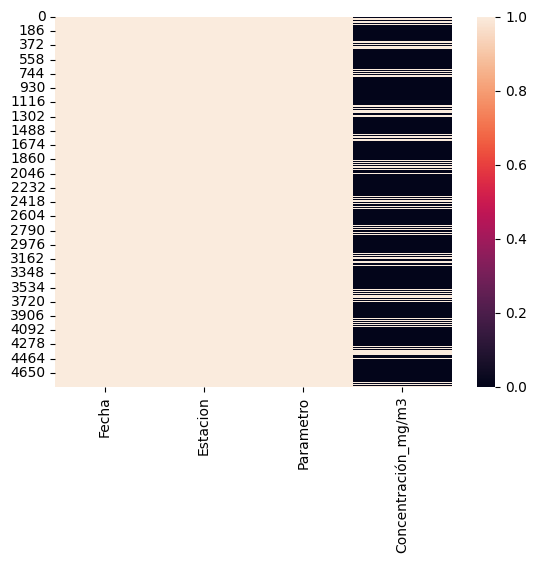

In [41]:
sns.heatmap(df_res_pm10.notna())

### **Gráfico de lineas de la fecha con respecto al PM10 según la estación**

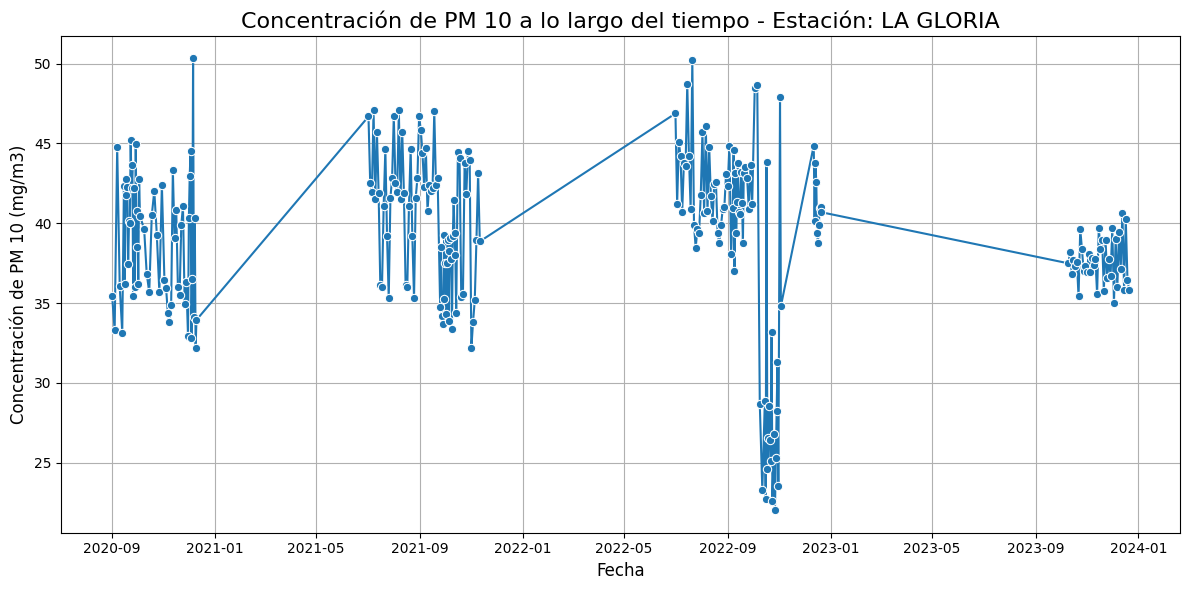

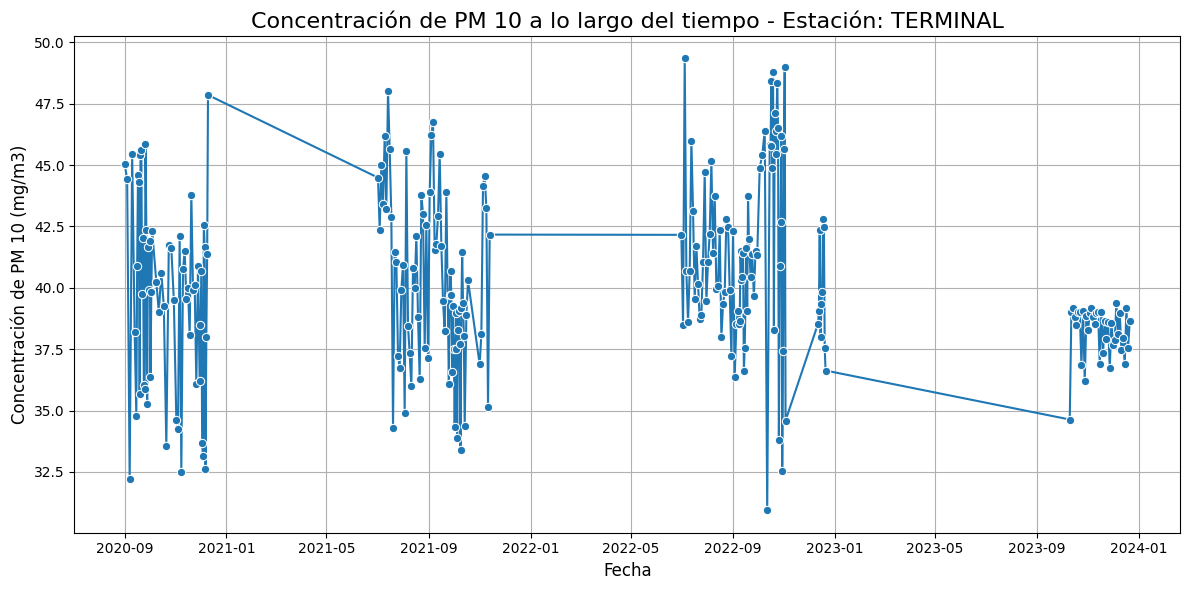

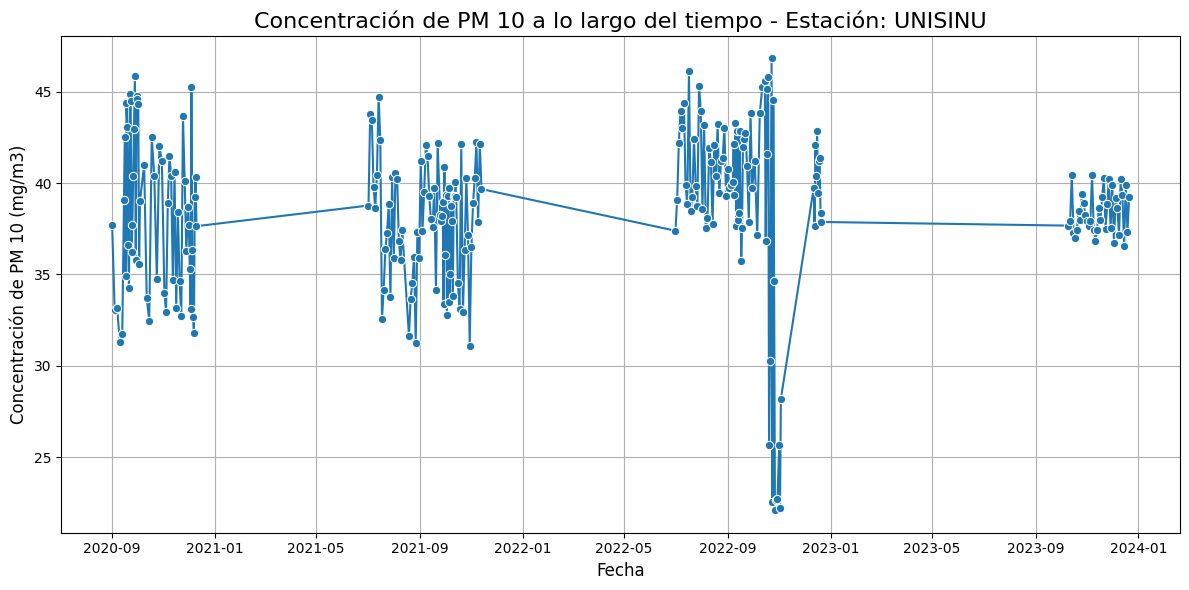

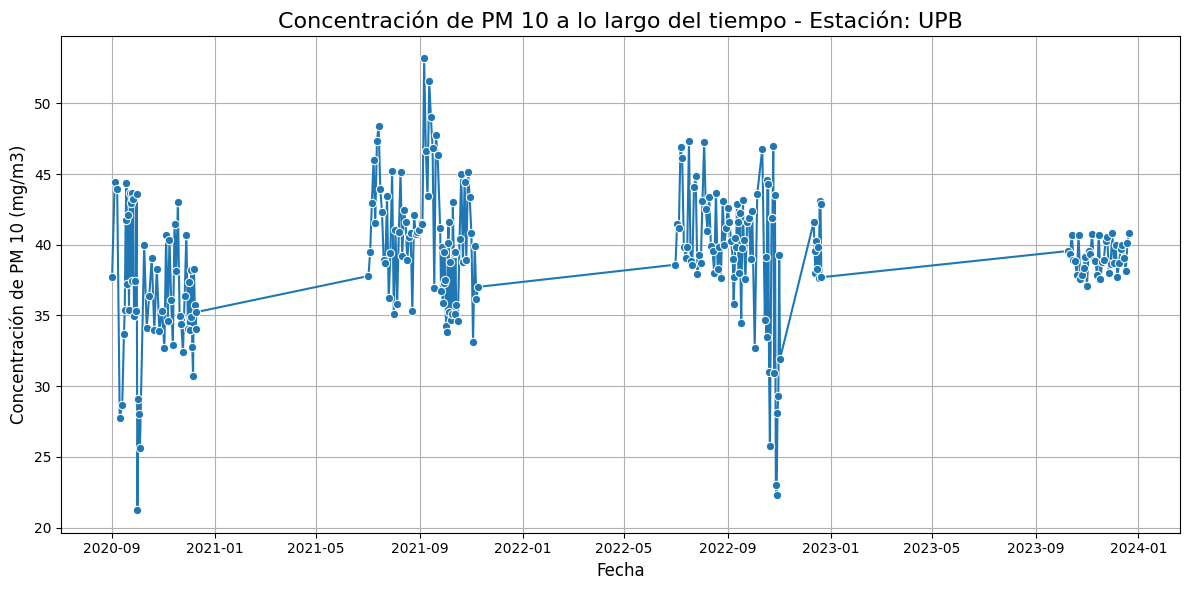

In [46]:
# Suprimir advertencias
warnings.filterwarnings("ignore", category=FutureWarning)

# Obtener la lista única de estaciones
estaciones = df_res_pm10['Estacion'].unique()

# Crear un gráfico para cada estación
for estacion in estaciones:
    # Filtrar los datos para la estación actual
    df_estacion = df_res_pm10[df_res_pm10['Estacion'] == estacion]
    
    # Configurar el tamaño de la figura
    plt.figure(figsize=(12, 6))
    
    # Crear el gráfico de líneas
    sns.lineplot(data=df_estacion, x='Fecha', y='Concentración_mg/m3', marker='o')
    
    # Configurar etiquetas y título
    plt.title(f'Concentración de PM 10 a lo largo del tiempo - Estación: {estacion}', fontsize=16)
    plt.xlabel('Fecha', fontsize=12)
    plt.ylabel('Concentración de PM 10 (mg/m3)', fontsize=12)
    plt.grid(True)
    
    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

:::{admonition} **Interpretación de las gráficas por estación para PM 10**
:class: tip

Esta son las interpretaciones de las series según las estaciones

1. **Estación: LA GLORIA**
    - **Patrones de datos**:
        - Se observa una tendencia general de valores de PM 10 oscilando entre **35 mg/m³ y 45 mg/m³**.
        - Hay gaps significativos en los datos en diferentes periodos, como entre finales de 2021 y mediados de 2022, y otro hacia finales de 2023.
    - **Picos notables**:
        - Existen algunos picos por encima de **45 mg/m³**, lo que podría indicar eventos de contaminación específicos o anomalías en la recolección de datos.

2. **Estación: TERMINAL**
    - **Patrones de datos**:
        - Los valores de PM 10 están distribuidos entre **35 mg/m³ y 45 mg/m³**, con algunos picos cercanos a **50 mg/m³**.
        - Hay períodos significativos sin datos (gaps) en 2022 y 2023, similares a los de LA GLORIA.
    - **Variabilidad**:
        - Existe una mayor dispersión en los datos, con variaciones más marcadas que en otras estaciones, especialmente en 2021 y 2022.

3. **Estación: UNISINU**
    - **Patrones de datos**:
        - Los valores de PM 10 muestran menor variabilidad, con la mayoría de los puntos en el rango de **35 mg/m³ a 45 mg/m³**.
        - Los gaps son más frecuentes en 2022 y finales de 2023.
    - **Tendencias generales**:
        - No se observan patrones estacionales claros debido a la discontinuidad en los datos.

4. **Estación: UPB**
    - **Patrones de datos**:
        - Similar a las otras estaciones, los valores de PM 10 oscilan principalmente entre **35 mg/m³ y 45 mg/m³**, con algunos picos que alcanzan los **50 mg/m³**.
        - Los gaps en los datos son evidentes en períodos similares (2022 y finales de 2023).
    - **Mayor estabilidad en ciertos periodos**:
        - Existen períodos con datos más completos, pero no permiten identificar una tendencia clara a largo plazo.


**Conclusiones generales**

1. **Falta de datos continuos**:
   - Todas las estaciones presentan gaps significativos en los datos, lo que dificulta la identificación de patrones estacionales o tendencias a largo plazo.

2. **Valores típicos de PM 10**:
   - Los valores de PM 10 se encuentran mayormente en el rango de **35 mg/m³ a 45 mg/m³**, lo que sugiere un nivel de contaminación moderado en las estaciones analizadas.

3. **Picos de contaminación**:
   - En algunas estaciones, como TERMINAL y UPB, los picos de contaminación por encima de **45 mg/m³** podrían estar relacionados con eventos específicos de contaminación, como tráfico pesado o condiciones meteorológicas.

4. **Dificultad para análisis temporal**:
   - Debido a los gaps en los datos, un análisis temporal robusto requeriría imputación de valores faltantes o el uso de datos complementarios.

**Recomendaciones**

1. **Imputación de valores faltantes**:
   - Aplicar técnicas como interpolación para completar los gaps en los datos.

2. **Monitoreo más constante**:
   - Implementar estrategias para garantizar la continuidad en la recolección de datos en las estaciones.

3. **Análisis por períodos completos**:
   - Enfocarse en períodos con datos más consistentes para analizar posibles tendencias o correlaciones.

4. **Investigación de picos de contaminación**:
   - Identificar las posibles causas de los picos en PM 10, como eventos climáticos o actividades humanas.

:::


* Hagamos un diagrama de cajas y bigoyes del PM 10 segun la estación cada año

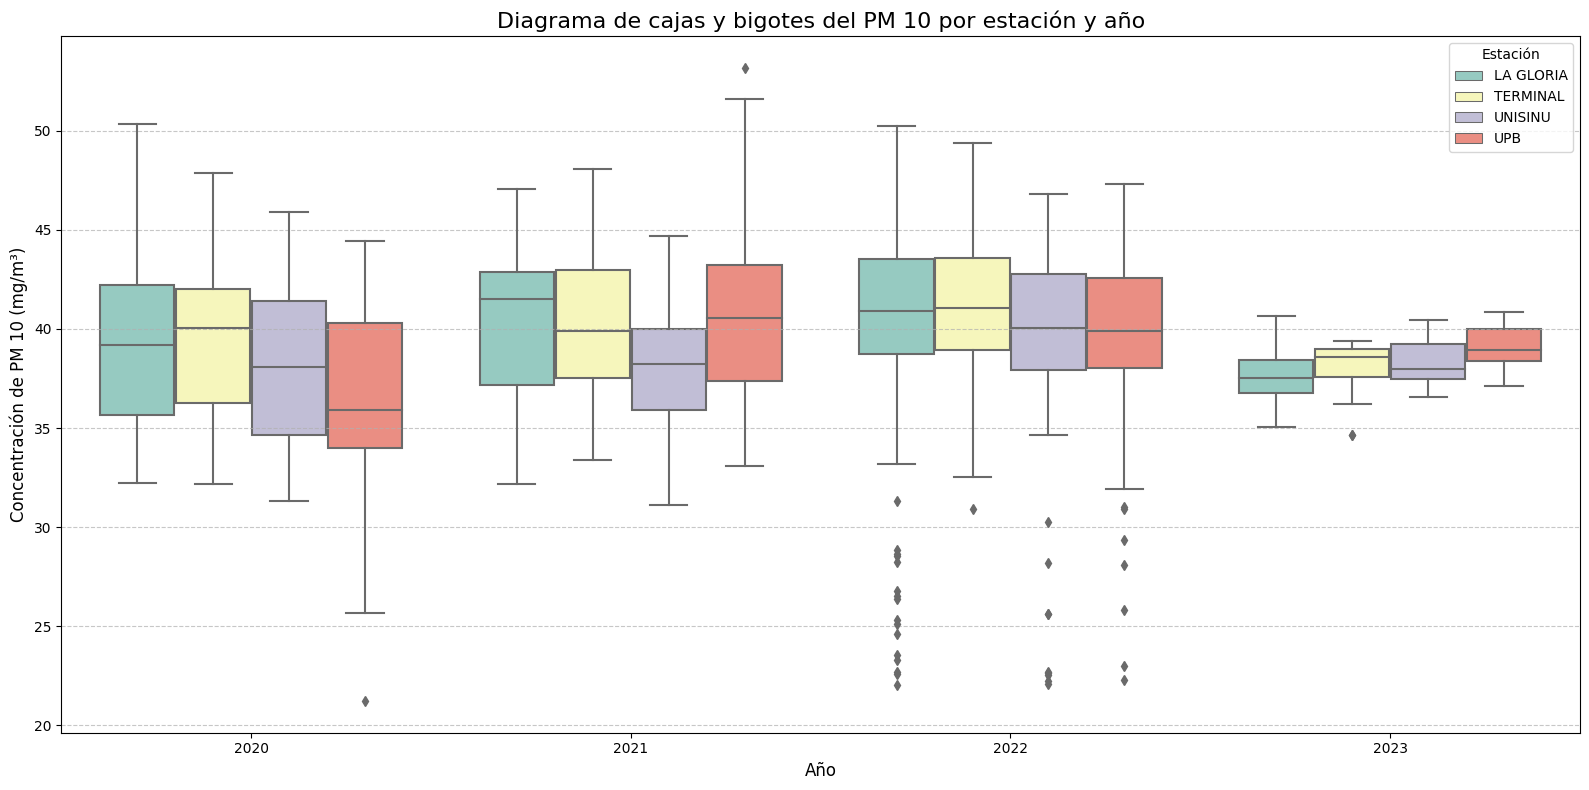

In [103]:
# Asegurar que la columna 'Fecha' esté en formato datetime usando .loc
pm_10 = datos_recopilados[datos_recopilados['Parametro'] == 'PM 10'].copy()
pm_10.loc[:, 'Fecha'] = pd.to_datetime(pm_10['Fecha'])

# Crear una nueva columna 'Año' a partir de la fecha
pm_10.loc[:, 'Año'] = pm_10['Fecha'].dt.year

# Crear el diagrama de cajas y bigotes
plt.figure(figsize=(16, 8))
sns.boxplot(
    data=pm_10,
    x='Año',
    y='Concentración_mg/m3',
    hue='Estacion',
    showfliers=True,  # Mostrar valores atípicos
    palette='Set3'
)

# Configuración del gráfico
plt.title("Diagrama de cajas y bigotes del PM 10 por estación y año", fontsize=16)
plt.xlabel("Año", fontsize=12)
plt.ylabel("Concentración de PM 10 (mg/m³)", fontsize=12)
plt.legend(title="Estación", loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

:::{admonition} **Interpretación del Diagrama de Cajas y Bigotes del PM 10 por Estación y Año**
:class: tip

El diagrama de cajas y bigotes presenta la distribución de las concentraciones de PM 10 en función del año y desglosadas por estación: **LA GLORIA**, **TERMINAL**, **UNISINU**, y **UPB**. Este análisis permite observar las diferencias y variabilidad en la calidad del aire en cada estación a lo largo del tiempo.

1. **Distribución por estación:**
   - **LA GLORIA**:
     - Muestra una distribución más consistente con valores intercuartiles más compactos. Sin embargo, presenta valores atípicos bajos en algunos años, indicando episodios de menor concentración de PM 10.
   - **TERMINAL**:
     - Presenta un comportamiento similar a **LA GLORIA** en términos de rango intercuartil, pero con valores ligeramente más altos en general.
   - **UNISINU**:
     - Exhibe una mayor dispersión en algunos años, con valores atípicos significativamente bajos en 2022, lo que podría indicar condiciones puntuales favorables de calidad del aire.
   - **UPB**:
     - La distribución es relativamente uniforme, pero con algunos valores atípicos hacia los extremos en años recientes.

2. **Tendencia temporal:**
   - A lo largo de los años, se observa una reducción en la variabilidad de las concentraciones en la mayoría de las estaciones. Esto puede indicar una mejora en el control de emisiones o condiciones climáticas más uniformes.
   - El rango intercuartil en todas las estaciones tiende a mantenerse consistente, reflejando condiciones estables en la mayoría de los casos.

3. **Valores atípicos:**
   - Los valores atípicos bajos en estaciones como **UNISINU** y **LA GLORIA** podrían estar asociados a eventos puntuales de mejor calidad del aire.
   - Los valores altos en estaciones como **UPB** podrían deberse a episodios específicos de contaminación, como fenómenos meteorológicos o incrementos locales de emisiones.

4. **Comparación entre estaciones:**
   - Las estaciones **LA GLORIA** y **TERMINAL** presentan distribuciones similares en la mayoría de los años, sugiriendo condiciones de calidad del aire comparables.
   - **UNISINU** muestra una mayor variabilidad en comparación con las demás estaciones, especialmente en años recientes.
   - **UPB** presenta un rango más amplio en algunos años, lo que refleja mayor fluctuación en la calidad del aire.

**Conclusión:**

El diagrama evidencia diferencias significativas en las concentraciones de PM 10 según la estación y el año, destacando la importancia de analizar estos datos de manera segmentada. 

:::


### **Descriptivo e inferencial del PM 10 según la estación**

Para realizar este análisis, no haremos imputación de datos por la fecha faltante, usaremos los datos en crudo.

In [61]:
# Filtrar los datos para PM 10
pm_10 = datos_recopilados[datos_recopilados['Parametro'] == 'PM 10']

# Generar la tabla resumen por estación
resumen_pm10 = pm_10.groupby('Estacion')['Concentración_mg/m3'].agg(
    n='count',
    media='mean',
    desviacion_estandar='std',
    mediana='median',
    min='min',
    max='max',
    Q1=lambda x: x.quantile(0.25),
    Q3=lambda x: x.quantile(0.75)
).reset_index()

# Agregar una fila con el total de PM 10
total_pm10 = pm_10['Concentración_mg/m3'].agg(
    n='count',
    media='mean',
    desviacion_estandar='std',
    mediana='median',
    min='min',
    max='max',
    Q1=lambda x: x.quantile(0.25),
    Q3=lambda x: x.quantile(0.75)
)
total_pm10_df = pd.DataFrame([total_pm10]).assign(Estacion='Total')

# Unir el total con el resumen por estación
resumen_pm10_final = pd.concat([resumen_pm10, total_pm10_df], ignore_index=True)

resumen_pm10_final

,Estacion,n,media,desviacion_estandar,mediana,min,max,Q1,Q3
0,LA GLORIA,256.0,39.140948,5.071278,39.652347,22.02,50.33,36.180000,42.4300
1,TERMINAL,253.0,40.167104,3.577234,39.700000,30.94,49.35,38.000000,42.3600
2,UNISINU,252.0,38.447504,4.287586,38.869985,22.10,46.82,36.799190,41.1750
3,UPB,253.0,39.092790,4.649564,39.370004,21.23,53.18,37.113808,41.6100
4,Total,1014.0,39.212630,4.468585,39.360000,21.23,53.18,37.138973,42.0475


:::{admonition} **Interpretación de la tabla: Resumen de PM 10 por estación y total**
:class: tip

La tabla proporciona un análisis descriptivo de las concentraciones de PM 10 en cuatro estaciones: **LA GLORIA**, **TERMINAL**, **UNISINU** y **UPB**, así como un resumen total.

1. **Total (Todas las estaciones)**
    - **Cantidad de datos (n)**: 1014 registros en total.
    - **Concentración promedio (media)**: **39.21 mg/m³**, con una mediana de **39.36 mg/m³**, lo que indica una distribución equilibrada.
    - **Variabilidad**:
        - La desviación estándar es **4.47 mg/m³**, mostrando una variabilidad general moderada entre todas las estaciones.
    - **Rango y cuartiles**:
        - Los valores totales oscilan entre **21.23 mg/m³** y **53.18 mg/m³**, con el 50% de los datos entre **37.14 mg/m³** (Q1) y **42.05 mg/m³** (Q3).

2. **Estación: LA GLORIA**
    - **Cantidad de datos (n)**: 256 registros disponibles.
    - **Concentración promedio (media)**: **39.14 mg/m³**, cercana a la mediana (**39.65 mg/m³**), lo que indica una distribución balanceada.
    - **Variabilidad**:
        - La desviación estándar es **5.07 mg/m³**, lo que sugiere una moderada variabilidad en las mediciones.
    - **Rango y cuartiles**:
        - Los valores van desde **22.02 mg/m³** a **50.33 mg/m³**, con el 50% de los datos entre **36.18 mg/m³** (Q1) y **42.43 mg/m³** (Q3).

3. **Estación: TERMINAL**
    - **Cantidad de datos (n)**: 253 registros disponibles.
    - **Concentración promedio (media)**: **40.17 mg/m³**, cercana a la mediana (**39.70 mg/m³**).
    - **Variabilidad**:
        - La desviación estándar es **3.58 mg/m³**, indicando una menor variabilidad en comparación con otras estaciones.
    - **Rango y cuartiles**:
        - Los valores están entre **30.94 mg/m³** y **49.35 mg/m³**, con el 50% de los datos entre **38.00 mg/m³** (Q1) y **42.36 mg/m³** (Q3).

4. **Estación: UNISINU**
    - **Cantidad de datos (n)**: 252 registros disponibles.
    - **Concentración promedio (media)**: **38.45 mg/m³**, con una mediana de **38.87 mg/m³**.
    - **Variabilidad**:
        - La desviación estándar es **4.29 mg/m³**, lo que indica variabilidad moderada.
    - **Rango y cuartiles**:
        - Los valores están entre **22.10 mg/m³** y **46.82 mg/m³**, con el 50% de los datos entre **36.80 mg/m³** (Q1) y **41.18 mg/m³** (Q3).

5. **Estación: UPB**
    - **Cantidad de datos (n)**: 253 registros disponibles.
    - **Concentración promedio (media)**: **39.09 mg/m³**, similar a la mediana de **39.37 mg/m³**.
    - **Variabilidad**:
        - La desviación estándar es **4.65 mg/m³**, reflejando una mayor dispersión en comparación con otras estaciones.
    - **Rango y cuartiles**:
        - Los valores oscilan entre **21.23 mg/m³** y **53.18 mg/m³**, con el 50% de los datos entre **37.11 mg/m³** (Q1) y **41.61 mg/m³** (Q3).

**Conclusiones**

1. **Uniformidad en los datos**:
   - Todas las estaciones muestran valores de concentración promedio y mediana similares, lo que refleja condiciones de calidad del aire comparables.

2. **Mayor variabilidad en UPB**:
   - La estación **UPB** tiene el rango más amplio (**21.23 mg/m³ a 53.18 mg/m³**) y la mayor desviación estándar (**4.65 mg/m³**), lo que podría indicar condiciones ambientales más fluctuantes.

3. **Concentraciones más estables en TERMINAL**:
   - La estación **TERMINAL** presenta la menor variabilidad, con una desviación estándar de **3.58 mg/m³** y un rango relativamente estrecho.
:::

* Agreguemos el año a la tabla anterior

In [34]:
# Crear una copia explícita del DataFrame original
pm10_data = datos_recopilados[datos_recopilados['Parametro'] == 'PM 10'].copy()

# Convertir la columna 'Fecha' a tipo datetime
pm10_data['Fecha'] = pd.to_datetime(pm10_data['Fecha'])

# Crear una nueva columna para el año
pm10_data['Año'] = pm10_data['Fecha'].dt.year

# Calcular las estadísticas agrupadas por año y estación
pm10_summary = pm10_data.groupby(['Año', 'Estacion'])['Concentración_mg/m3'].agg(
    n='count',
    promedio='mean',
    desviacion_estandar='std',
    mediana='median',
    minimo='min',
    maximo='max',
    Q1=lambda x: x.quantile(0.25),
    Q3=lambda x: x.quantile(0.75)
).reset_index()

pm10_summary

,Año,Estacion,n,promedio,desviacion_estandar,mediana,minimo,maximo,Q1,Q3
0,2020,LA GLORIA,58,38.786379,3.975092,39.165000,32.210000,50.330000,35.680000,42.187500
1,2020,TERMINAL,58,39.687414,3.861337,40.060000,32.190000,47.860000,36.237500,42.015000
2,2020,UNISINU,58,38.212759,4.251651,38.060000,31.310000,45.880000,34.665000,41.422500
3,2020,UPB,58,36.446983,4.968652,35.900000,21.230000,44.430000,33.992500,40.272500
4,2021,LA GLORIA,76,40.345658,4.043786,41.490000,32.170000,47.070000,37.162500,42.887500
5,2021,TERMINAL,71,40.246761,3.533748,39.910000,33.380000,48.040000,37.525000,42.975000
6,2021,UNISINU,74,37.860270,3.184760,38.210000,31.100000,44.700000,35.900000,39.977500
7,2021,UPB,75,40.669067,4.301814,40.550000,33.100000,53.180000,37.390000,43.210000
8,2022,LA GLORIA,84,38.989405,7.069906,40.895000,22.020000,50.250000,38.710000,43.547500
9,2022,TERMINAL,86,41.325233,3.698576,41.070000,30.940000,49.350000,38.942500,43.585000


:::{admonition} **Interpretación del análisis de concentración de PM 10 por año y estación**
:class: tip 

La tabla resume las estadísticas descriptivas de la concentración de PM 10 (en mg/m³) para cada estación y año en el período 2020-2023. A continuación, se destacan los principales hallazgos:

1. **2020**:
   - **TERMINAL** presenta el promedio más alto (**39.69 mg/m³**) y una desviación estándar moderada (**3.86 mg/m³**), lo que indica valores relativamente consistentes.
   - **UPB** exhibe el promedio más bajo (**36.45 mg/m³**) con la mayor variabilidad (**4.97 mg/m³**), lo que refleja una mayor dispersión en las mediciones.

2. **2021**:
   - **UPB** muestra un aumento en la concentración promedio (**40.67 mg/m³**) y el rango máximo (**53.18 mg/m³**), destacándose como la estación con mayor concentración de PM 10 en este año.
   - **UNISINU**, con un promedio de **37.86 mg/m³**, tiene la menor variabilidad (**3.18 mg/m³**), lo que indica datos más consistentes.

3. **2022**:
   - **TERMINAL** lidera con el promedio más alto (**41.33 mg/m³**) y una desviación estándar baja (**3.70 mg/m³**), lo que sugiere un aumento sostenido en las concentraciones de este año.
   - **LA GLORIA** muestra una alta variabilidad con una desviación estándar de **7.07 mg/m³**, lo que podría estar relacionado con factores locales.

4. **2023**:
   - Las concentraciones promedio disminuyen en comparación con años anteriores, siendo **LA GLORIA** la estación con el promedio más bajo (**37.61 mg/m³**) y **UPB** con el más alto (**39.15 mg/m³**).
   - La variabilidad en todas las estaciones es significativamente menor, con desviaciones estándar inferiores a **1.5 mg/m³**, lo que refleja mediciones más homogéneas.

**Conclusiones**:

El análisis revela fluctuaciones en las concentraciones de PM 10 entre estaciones y años. Mientras que **TERMINAL** y **UPB** presentan consistentemente mayores concentraciones promedio en la mayoría de los años, **UNISINU** y **LA GLORIA** tienden a registrar menores valores con mayor variabilidad en ciertos períodos. Las tendencias observadas resaltan la importancia de investigar factores ambientales y de fuentes de contaminación específicas para comprender las variaciones en las concentraciones de PM 10.

:::


* Hagamos un gráfico de densidad del PM 10 según las estaciones

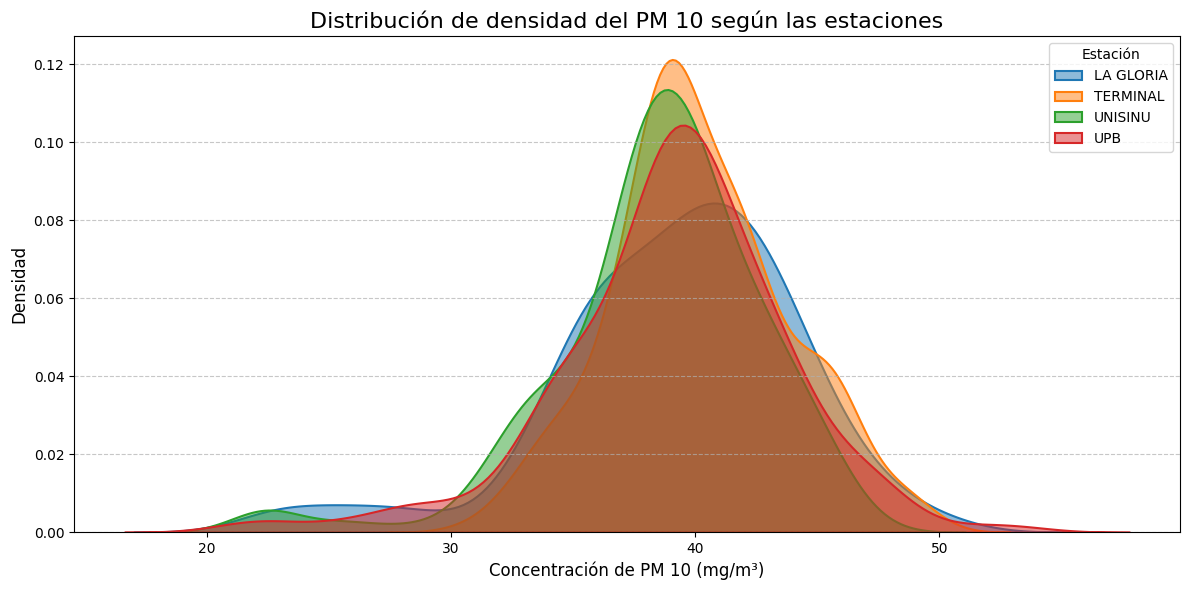

In [96]:
# Limpiar los datos: eliminar filas con valores nulos en 'Estacion' o 'Concentración_mg/m3'
pm_10_cleaned = pm_10.dropna(subset=['Estacion', 'Concentración_mg/m3'])

# Confirmar que los datos son categóricos
pm_10_cleaned['Estacion'] = pm_10_cleaned['Estacion'].astype('category')

# Crear el gráfico de densidad manualmente para cada estación
plt.figure(figsize=(12, 6))

for estacion in pm_10_cleaned['Estacion'].cat.categories:
    subset = pm_10_cleaned[pm_10_cleaned['Estacion'] == estacion]
    sns.kdeplot(
        data=subset,
        x="Concentración_mg/m3",
        label=estacion,
        fill=True,
        alpha=0.5,
        linewidth=1.5
    )

# Configuración del gráfico
plt.title("Distribución de densidad del PM 10 según las estaciones", fontsize=16)
plt.xlabel("Concentración de PM 10 (mg/m³)", fontsize=12)
plt.ylabel("Densidad", fontsize=12)
plt.legend(title="Estación", loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

:::{admonition} **Grafico de densidad PM 10**
:class: tip

El gráfico de densidad muestra la distribución de las concentraciones de PM 10 en las diferentes estaciones: **LA GLORIA**, **TERMINAL**, **UNISINU** y **UPB**. Se observa que las concentraciones presentan curvas de densidad similares en forma general, con algunas variaciones en la ubicación y altura de los picos, lo que refleja diferencias en las distribuciones entre estaciones.

La estación **TERMINAL** muestra una distribución con un pico más alto, lo que indica una mayor densidad de concentraciones alrededor de su promedio. Esto sugiere que los valores de concentración en esta estación están menos dispersos y son más consistentes. En contraste, las estaciones **LA GLORIA** y **UNISINU** presentan distribuciones ligeramente más amplias, indicando una mayor variabilidad en las mediciones de concentración. 

La estación **UPB**, aunque sigue una tendencia similar a las demás, muestra una menor densidad en el rango más alto de concentraciones de PM 10. Esto puede estar relacionado con condiciones ambientales o fuentes específicas que afectan las concentraciones en esta estación.

:::


* Hagamos las pruebas de normalidad de la variable PM 10 y tambien según la estación

In [69]:
# Inicializar un diccionario para almacenar resultados
normalidad_resultados_pm10 = {
    'Prueba': [],
    'Estación': [],
    'n': [],
    'Estadístico': [],
    'p-valor': []
}

# Analizar normalidad para cada estación y total
for estacion in resumen_pm10['Estacion']:
    if estacion != 'Total':
        # Filtrar datos por estación
        pm10_estacion = pm_10[pm_10['Estacion'] == estacion]['Concentración_mg/m3']
    else:
        # Tomar todos los datos para el total
        pm10_estacion = pm_10['Concentración_mg/m3']

    # Agregar el número de observaciones (n)
    n = len(pm10_estacion)

    # Prueba de Kolmogorov-Smirnov
    ks_result = ks_1samp((pm10_estacion - np.mean(pm10_estacion)) / np.std(pm10_estacion), cdf=norm.cdf)
    normalidad_resultados_pm10['Prueba'].append('Kolmogorov-Smirnov')
    normalidad_resultados_pm10['Estación'].append(estacion)
    normalidad_resultados_pm10['n'].append(n)
    normalidad_resultados_pm10['Estadístico'].append(ks_result.statistic)
    normalidad_resultados_pm10['p-valor'].append(round(ks_result.pvalue, 3))

# Calcular para el total sin descomponer por estación
pm10_total = pm_10['Concentración_mg/m3']
n_total = len(pm10_total)
ks_total = ks_1samp((pm10_total - np.mean(pm10_total)) / np.std(pm10_total), cdf=norm.cdf)
normalidad_resultados_pm10['Prueba'].append('Kolmogorov-Smirnov')
normalidad_resultados_pm10['Estación'].append('Total (Sin Descomponer)')
normalidad_resultados_pm10['n'].append(n_total)
normalidad_resultados_pm10['Estadístico'].append(ks_total.statistic)
normalidad_resultados_pm10['p-valor'].append(round(ks_total.pvalue, 3))

# Convertir los resultados a un DataFrame
normalidad_resultados_pm10_df = pd.DataFrame(normalidad_resultados_pm10)

# Reordenar columnas para que 'n' aparezca después de 'Estación'
normalidad_resultados_pm10_df = normalidad_resultados_pm10_df[['Estación', 'n', 'Prueba', 'Estadístico', 'p-valor']]

normalidad_resultados_pm10_df

,Estación,n,Prueba,Estadístico,p-valor
0,LA GLORIA,256,Kolmogorov-Smirnov,0.070016,0.155
1,TERMINAL,253,Kolmogorov-Smirnov,0.064121,0.239
2,UNISINU,252,Kolmogorov-Smirnov,0.113812,0.003
3,UPB,253,Kolmogorov-Smirnov,0.095958,0.018
4,Total (Sin Descomponer),1014,Kolmogorov-Smirnov,0.078140,0.000


:::{admonition} **Análisis de Normalidad de las Concentraciones de PM 10**
:class: tip 

La tabla muestra los resultados de la prueba de Kolmogorov-Smirnov aplicada a las concentraciones de PM 10 por estación y para el total general, con el propósito de evaluar la normalidad de los datos. En la estación **LA GLORIA**, con 256 observaciones, el estadístico KS fue 0.070 y el p-valor de 0.155, indicando que las concentraciones de PM 10 podrían seguir una distribución normal al no rechazarse la hipótesis nula. De manera similar, en la estación **TERMINAL**, con 253 observaciones, el estadístico KS fue 0.064 y el p-valor de 0.239, lo que también sugiere una distribución normal. En contraste, las estaciones **UNISINU** y **UPB** no cumplieron con la normalidad. En **UNISINU**, con 252 observaciones, el estadístico KS fue 0.114 y el p-valor de 0.003, mientras que en **UPB**, con 253 observaciones, el estadístico KS fue 0.096 y el p-valor de 0.018, indicando que en ambas estaciones las concentraciones de PM 10 no siguen una distribución normal. Para el total general, considerando 1014 observaciones de todas las estaciones combinadas, el estadístico KS fue 0.078 y el p-valor de 0.000, concluyendo que las concentraciones de PM 10 no se distribuyen de forma normal cuando se analizan de manera conjunta. Estos resultados destacan la necesidad de segmentar los análisis por estación, dado que las condiciones varían significativamente. Para estaciones como **UNISINU** y **UPB**, donde no se cumple la normalidad.

:::


* Veamos la prueba no paramétrica `Kruskal-Wallis`, para ver si hay diferencia entre las estaciones por el PM10

In [73]:
# Realizar la prueba de Kruskal-Wallis para PM 10 según la estación
pm10_kruskal = kruskal(
    *[pm_10[pm_10['Estacion'] == estacion]['Concentración_mg/m3'].dropna() 
      for estacion in pm_10['Estacion'].unique()]
)

# Resultados de Kruskal-Wallis
kruskal_resultado = {
    'Prueba': 'Kruskal-Wallis',
    'Estadístico': pm10_kruskal.statistic,
    'p-valor': pm10_kruskal.pvalue
}

# Convertir los resultados a un DataFrame para mejor visualización
kruskal_resultado_df = pd.DataFrame([kruskal_resultado])

kruskal_resultado_df 

,Prueba,Estadístico,p-valor
0,Kruskal-Wallis,15.404458,0.001502


:::{admonition} **Interpretación de Kruskal-Wallis del PM 10**
:class: tip

El p-valor obtenido (0.0015) indica que hay diferencias estadísticamente significativas en las concentraciones de PM 10 entre las diferentes estaciones de monitoreo. Esto sugiere que al menos una de las estaciones tiene una mediana de concentración de PM 10 significativamente diferente de las demás, lo cual resalta la importancia de analizar las estaciones individualmente para entender mejor las posibles fuentes de estas variaciones.

:::

* Ahora veamos que estaciones son diferentes.

In [74]:
# Realizar la prueba post-hoc de Dunn con ajuste de Bonferroni
pm10_posthoc_dunn = sp.posthoc_dunn(
    pm_10, 
    val_col='Concentración_mg/m3', 
    group_col='Estacion', 
    p_adjust='bonferroni'
)

# Mostrar los resultados de la prueba post-hoc de Dunn
pm10_posthoc_dunn


,LA GLORIA,TERMINAL,UNISINU,UPB
LA GLORIA,1.000000,0.671318,0.128058,1.000000
TERMINAL,0.671318,1.000000,0.000630,0.176340
UNISINU,0.128058,0.000630,1.000000,0.531857
UPB,1.000000,0.176340,0.531857,1.000000


:::{admonition} **Conclusiones de la prueba post-hoc de Dunn para PM 10**
:class: tip 

Los resultados de la prueba post-hoc de Dunn muestran los p-valores ajustados para las comparaciones múltiples entre las estaciones en relación con las concentraciones de PM 10. Las conclusiones más destacadas son las siguientes:

1. **LA GLORIA**:
   - No se encontraron diferencias estadísticamente significativas con las demás estaciones:
     - Con **UPB**: p-valor = 1.000.
     - Con **TERMINAL**: p-valor = 0.671.
     - Con **UNISINU**: p-valor = 0.128.

2. **TERMINAL**:
   - Existe una diferencia estadísticamente significativa con **UNISINU** (p-valor = 0.0006), indicando que las concentraciones de PM 10 son diferentes entre estas estaciones.
   - No se encontraron diferencias significativas con **UPB** (p-valor = 0.176).

3. **UNISINU**:
   - No se encontraron diferencias significativas con **UPB** (p-valor = 0.532).

En resumen, la prueba de Dunn confirma que las concentraciones de PM 10 en **TERMINAL** y **UNISINU** son significativamente diferentes, lo cual refuerza la importancia de considerar tratamientos separados para estas estaciones en el análisis. Para las demás comparaciones, no se encontraron diferencias significativas.

:::


## **Análisis del PM 2.5**

### **Datos faltantes del PM 2.5**

In [41]:
df_pm_2_5 = datos_recopilados[datos_recopilados['Parametro']=='PM 2.5']
df_pm_2_5 = df_pm_2_5.drop_duplicates(subset=['Fecha','Estacion'], keep='first')

df_pm_2_5.head()

,Estacion,Fecha,Parametro,Concentración_mg/m3
256,LA GLORIA,2022-11-03,PM 2.5,11.87
257,LA GLORIA,2022-11-02,PM 2.5,13.07
258,LA GLORIA,2022-11-01,PM 2.5,13.84
259,LA GLORIA,2022-10-31,PM 2.5,14.36
260,LA GLORIA,2022-10-30,PM 2.5,12.17


* Ingreso de fechas faltantes del PM 2.5

In [42]:
# Crear un índice de fechas continuo
nuevo_indice = pd.date_range(start=fecha_inicio, end=fecha_fin)

# Crear un DataFrame vacío para almacenar los resultados
df_res_pm_2_5 = pd.DataFrame()

# Reindexar por cada estación
for estacion, grupo in df_pm_2_5.groupby('Estacion'):
    # Reindexar el grupo utilizando el rango de fechas
    grupo_reindexado = (
        grupo.set_index('Fecha')
        .reindex(nuevo_indice)
        .reset_index()
    )
    # Asignar el nombre de la estación al grupo reindexado
    grupo_reindexado['Estacion'] = estacion
    # Rellenar los valores faltantes en "Parametro"
    grupo_reindexado['Parametro'] = grupo_reindexado['Parametro'].fillna('PM 10')
    # Renombrar la columna del índice
    grupo_reindexado.rename(columns={'index': 'Fecha'}, inplace=True)
    # Añadir al DataFrame final
    df_res_pm_2_5 = pd.concat([df_res_pm_2_5, grupo_reindexado], ignore_index=True)

# Verificar el resultado
df_res_pm_2_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4828 entries, 0 to 4827
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Fecha                4828 non-null   datetime64[ns]
 1   Estacion             4828 non-null   object        
 2   Parametro            4828 non-null   object        
 3   Concentración_mg/m3  338 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 151.0+ KB


In [43]:
df_va = df_res_pm_2_5.copy()

# Contar la cantidad de datos totales por estación
cantidad_datos_por_estacion = df_va.groupby('Estacion').size().reset_index(name='Cantidad de Datos')

# Contar la cantidad de datos no faltantes en "Concentración_mg/m3" por estación
datos_no_faltantes = df_va.groupby('Estacion')['Concentración_mg/m3'].apply(lambda x: x.notnull().sum()).reset_index(name='Cantidad de datos del PM 2.5 (no faltantes)')

# Revisar los datos faltantes por estación
missing_values_by_estacion = df_va.groupby('Estacion').apply(lambda x: x.isnull().sum())

# Calcular el porcentaje de valores faltantes por estación
missing_percentage_by_estacion = df_va.groupby('Estacion').apply(lambda x: (x.isnull().mean() * 100).round(2))

# Crear un DataFrame unificado
missing_data_by_estacion = cantidad_datos_por_estacion.copy()
missing_data_by_estacion = missing_data_by_estacion.merge(datos_no_faltantes, on='Estacion', how='left')
missing_data_by_estacion['Valores Faltantes'] = missing_values_by_estacion['Concentración_mg/m3'].values
missing_data_by_estacion['Porcentaje Faltante (%)'] = missing_percentage_by_estacion['Concentración_mg/m3'].values

missing_data_by_estacion

,Estacion,Cantidad de Datos,Cantidad de datos del PM 2.5 (no faltantes),Valores Faltantes,Porcentaje Faltante (%)
0,LA GLORIA,1207,78,1129,93.54
1,TERMINAL,1207,93,1114,92.29
2,UNISINU,1207,78,1129,93.54
3,UPB,1207,89,1118,92.63


:::{admonition} **Interpretación de la tabla**
:class: tip

La tabla muestra un análisis de los datos disponibles y faltantes del parámetro **PM 2.5** para cuatro estaciones: **LA GLORIA**, **TERMINAL**, **UNISINU** y **UPB**.

1. **Cantidad Total de Datos**
  - Cada estación tiene un total de **1207 observaciones**, lo que indica un período de monitoreo uniforme para todas las estaciones.

2. **Cantidad de Datos No Faltantes (PM 2.5)**
  - Los datos completos (no faltantes) para **PM 2.5** son extremadamente bajos:
    - **LA GLORIA**: 78 observaciones (6.46% de los datos totales).
    - **TERMINAL**: 93 observaciones (7.71% de los datos totales).
    - **UNISINU**: 78 observaciones (6.46% de los datos totales).
    - **UPB**: 89 observaciones (7.37% de los datos totales).

3. **Valores Faltantes**
  - El número de datos faltantes es muy alto en todas las estaciones:
    - **LA GLORIA** y **UNISINU** tienen **1129 valores faltantes** (93.54% de los datos totales).
    - **TERMINAL** tiene **1114 valores faltantes** (92.29% de los datos totales).
    - **UPB** tiene **1118 valores faltantes** (92.63% de los datos totales).

4. **Porcentaje de Datos Faltantes**
  - El porcentaje de datos faltantes supera el **92% en todas las estaciones**, lo que indica una gran discontinuidad en la recolección de datos para este parámetro.
:::

### **Gráfico de lineas de la fecha con respecto al PM 2.5 según la estación**

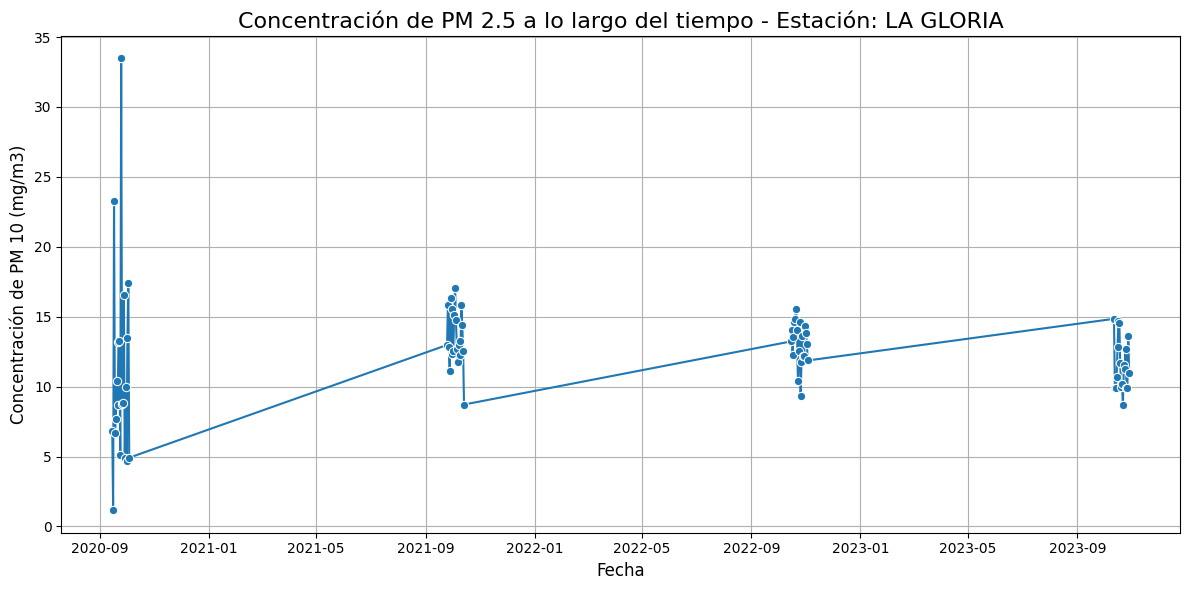

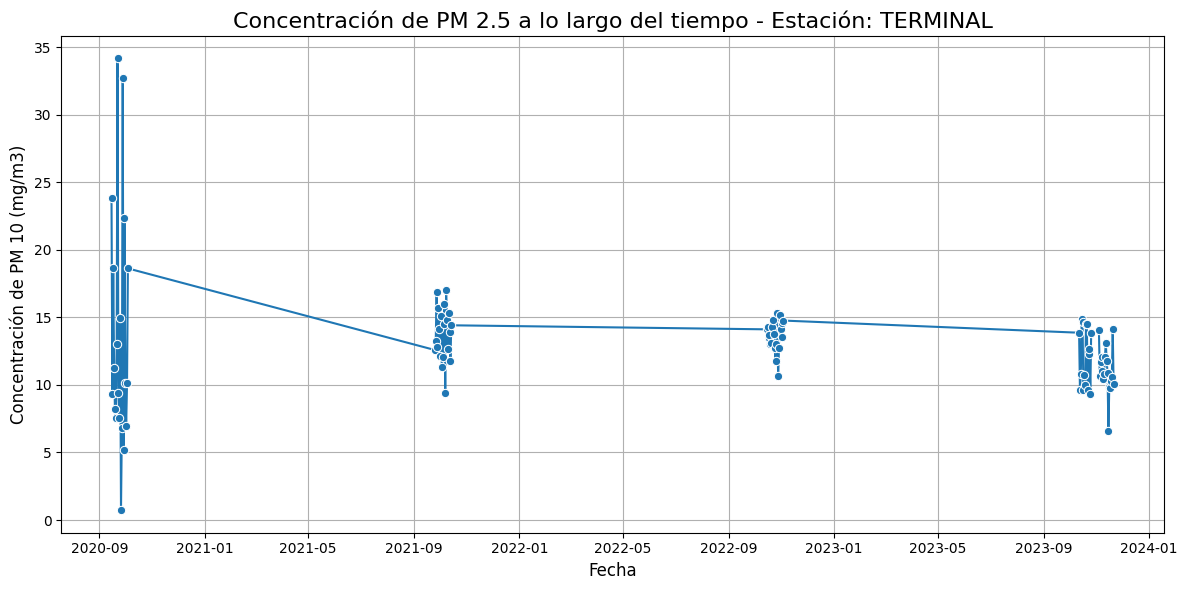

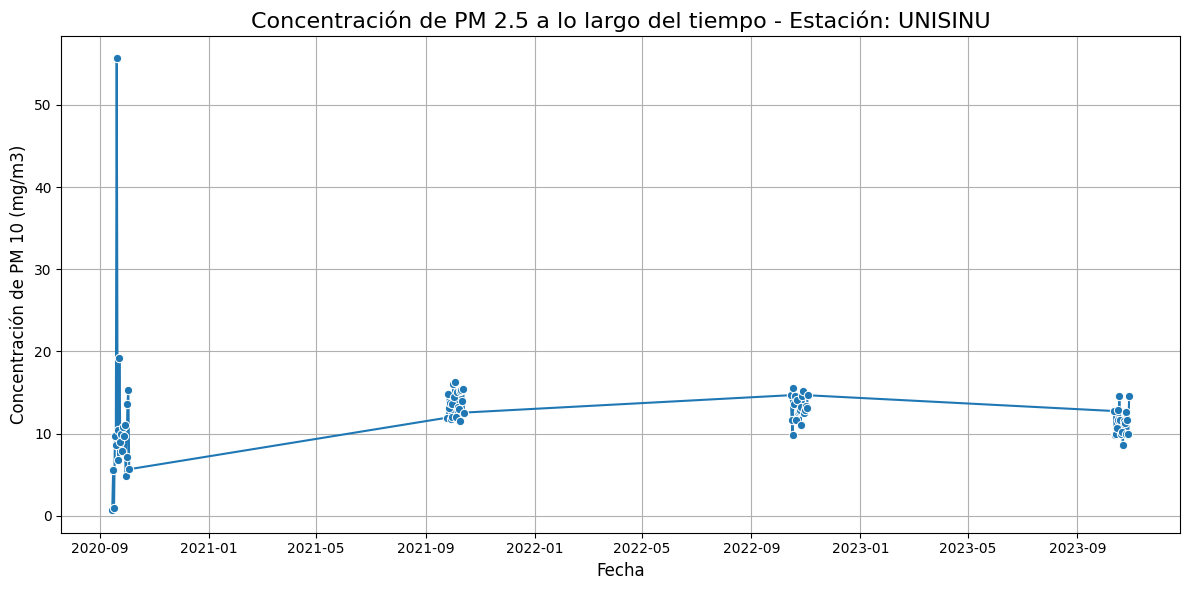

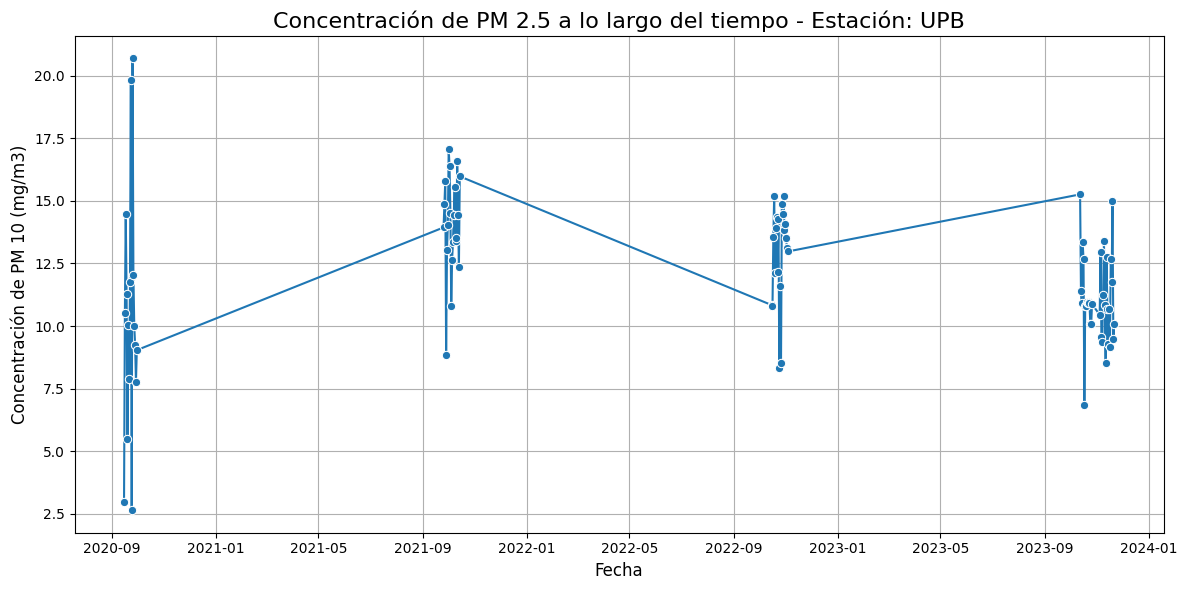

In [47]:
# Suprimir advertencias
warnings.filterwarnings("ignore", category=FutureWarning)

# Obtener la lista única de estaciones
estaciones = df_res_pm_2_5['Estacion'].unique()

# Crear un gráfico para cada estación
for estacion in estaciones:
    # Filtrar los datos para la estación actual
    df_estacion = df_res_pm_2_5[df_res_pm_2_5['Estacion'] == estacion]
    
    # Configurar el tamaño de la figura
    plt.figure(figsize=(12, 6))
    
    # Crear el gráfico de líneas
    sns.lineplot(data=df_estacion, x='Fecha', y='Concentración_mg/m3', marker='o')
    
    # Configurar etiquetas y título
    plt.title(f'Concentración de PM 2.5 a lo largo del tiempo - Estación: {estacion}', fontsize=16)
    plt.xlabel('Fecha', fontsize=12)
    plt.ylabel('Concentración de PM 10 (mg/m3)', fontsize=12)
    plt.grid(True)
    
    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

:::{admonition} **Interpretación de las gráficas por estación para PM 2.5**
:class: tip

Esta son las interpretaciones de las series según las estaciones

1. **Estación: LA GLORIA**
  - **Patrones de datos**:
    - Los valores de **PM 2.5** presentan **gaps significativos** en la recolección de datos, observándose mediciones en periodos muy específicos.
    - La concentración oscila mayormente entre **5 y 15 mg/m³**, con algunos picos por encima de los **30 mg/m³** al inicio del período.
  - **Tendencia general**:
    - Existe un ligero aumento en las concentraciones de PM 2.5 en las mediciones posteriores a 2021, aunque los datos son limitados para confirmar una tendencia sólida.

2. **Estación: TERMINAL**
  - **Patrones de datos**:
    - Similar a LA GLORIA, hay **gaps significativos** en los datos, con mediciones realizadas en periodos muy específicos.
    - Las concentraciones iniciales alcanzan hasta **20 mg/m³**, mientras que los periodos posteriores muestran valores más estables entre **5 y 15 mg/m³**.
  - **Tendencia general**:
    - Se observa una ligera disminución en las concentraciones promedio a lo largo del tiempo.

3. **Estación: UNISINU**
  - **Patrones de datos**:
    - Presenta menos puntos de datos y grandes gaps temporales.
    - La concentración inicial muestra un pico significativo por encima de **50 mg/m³**, que no se repite en las mediciones posteriores.
    - Las mediciones posteriores están en el rango de **5 a 15 mg/m³**.
  - **Tendencia general**:
    - Se aprecia un comportamiento más estable en los valores recientes, aunque limitado por la falta de continuidad en los datos.

4. **Estación: UPB**
  - **Patrones de datos**:
    - Los valores iniciales muestran mayor variabilidad, con concentraciones de **5 a 20 mg/m³** y algunos picos menores a lo largo del tiempo.
    - Los periodos posteriores presentan valores más estables, oscilando entre **5 y 15 mg/m³**, con gaps similares a otras estaciones.
  - **Tendencia general**:
    - Existe un patrón moderadamente estable en las mediciones recientes.

**Conclusiones generales**

1. **Gaps en los datos**:
   - Todas las estaciones presentan periodos largos sin datos, lo que dificulta realizar un análisis continuo o identificar patrones estacionales claros.

2. **Rango de concentraciones**:
   - Las concentraciones de PM 2.5 generalmente se encuentran entre **5 y 15 mg/m³**, con algunos picos significativos en ciertos periodos iniciales.

3. **Diferencias entre estaciones**:
   - Aunque los valores son similares entre estaciones, algunas como UNISINU muestran picos más altos en las primeras mediciones.

4. **Posibilidad de análisis temporal**:
   - Debido a la alta cantidad de datos faltantes, sería necesario imputar valores para realizar un análisis de tendencias o estacionalidad confiable.

**Recomendaciones**

1. **Imputación de valores faltantes**:
   - Completar los datos ausentes mediante técnicas como interpolación o modelos predictivos basados en variables relacionadas.

2. **Mejorar la recolección de datos**:
   - Implementar medidas para reducir los gaps en los datos futuros y garantizar una recolección más uniforme.

3. **Análisis por periodos específicos**:
   - Centrar el análisis en los periodos donde los datos sean más consistentes.

4. **Investigación de picos iniciales**:
   - Analizar las posibles causas de los picos altos al inicio del periodo (por encima de 30 mg/m³), que podrían estar relacionados con eventos específicos.

:::

* Hagamos un diagrama de cajas y bigoyes del PM 2.5 segun la estación cada año

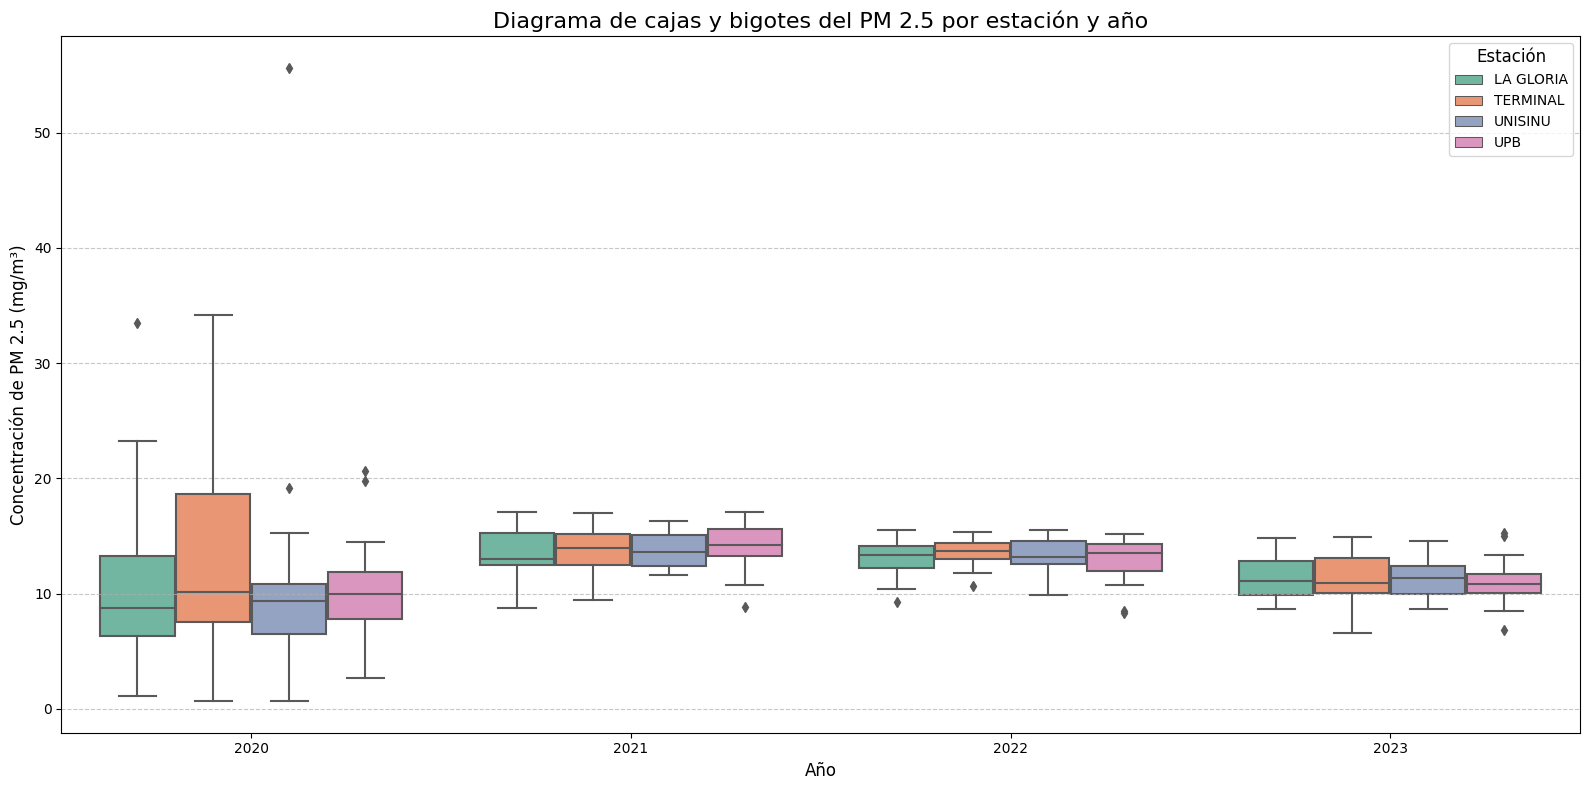

In [101]:
# Filtrar datos para PM 2.5
pm_25 = datos_recopilados[datos_recopilados['Parametro'] == 'PM 2.5'].copy()

# Convertir la columna 'Fecha' a formato datetime y agregar columna 'Año'
pm_25.loc[:, 'Fecha'] = pd.to_datetime(pm_25['Fecha'])
pm_25.loc[:, 'Año'] = pm_25['Fecha'].dt.year

# Crear el diagrama de cajas y bigotes
plt.figure(figsize=(16, 8))
sns.boxplot(
    data=pm_25,
    x='Año',
    y='Concentración_mg/m3',
    hue='Estacion',
    palette='Set2'
)

# Configuración del gráfico
plt.title('Diagrama de cajas y bigotes del PM 2.5 por estación y año', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Concentración de PM 2.5 (mg/m³)', fontsize=12)
plt.legend(title='Estación', fontsize=10, title_fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.tight_layout()
plt.show()



:::{admonition} **Interpretación del Diagrama de Cajas y Bigotes del PM 2.5 por Estación y Año**
:class: tip 

El gráfico muestra la variación en las concentraciones de **PM 2.5** por estación y año, proporcionando una visión clara de las distribuciones, rangos y valores atípicos en cada combinación de estación y año.

1. **Variación anual:**
   - En **2020**, se observan rangos más amplios de concentraciones, especialmente en la estación **TERMINAL**, que presenta valores máximos significativamente mayores en comparación con otras estaciones.
   - A partir de **2021**, las concentraciones muestran una mayor consistencia entre las estaciones, con rangos más estrechos y menor dispersión.
   - Para **2023**, los rangos son más compactos y similares entre estaciones, lo que sugiere una tendencia hacia concentraciones más uniformes en todas las estaciones.

2. **Diferencias entre estaciones:**
   - **TERMINAL** destaca en 2020 con un rango superior al de las demás estaciones, alcanzando valores máximos cercanos a 35 mg/m³.
   - **UNISINU** presenta valores más dispersos en 2020, incluyendo algunos valores atípicos que superan significativamente los valores típicos de esa estación.
   - **LA GLORIA** y **UPB** tienden a mostrar rangos más consistentes a lo largo de los años, con medianas similares y menor dispersión.

3. **Tendencias generales:**
   - A lo largo de los años, la mediana de las concentraciones de **PM 2.5** se mantiene relativamente estable para todas las estaciones, oscilando entre 10 y 15 mg/m³.
   - Se observa una disminución general en la cantidad y magnitud de valores atípicos a medida que avanzan los años, lo que podría reflejar mejoras en las condiciones ambientales o en la medición.

**Conclusión:**
El diagrama de cajas y bigotes muestra que las concentraciones de **PM 2.5** varían tanto entre estaciones como entre años. En 2020, las estaciones **TERMINAL** y **UNISINU** experimentaron valores extremos y una mayor dispersión, mientras que en años posteriores, las concentraciones se estabilizan. Este análisis sugiere que es importante considerar tanto la estación como el año al evaluar las concentraciones de **PM 2.5**, ya que los patrones de variación pueden diferir significativamente según estas variables.

:::


### **Descriptivo e inferencial del PM 2.5 según la estación**

Para realizar este análisis, no haremos imputación de datos por la fecha faltante, usaremos los datos en crudo.

In [75]:
# Filtrar los datos para PM 2.5
pm_25 = datos_recopilados[datos_recopilados['Parametro'] == 'PM 2.5']

# Generar la tabla resumen por estación para PM 2.5
resumen_pm25 = pm_25.groupby('Estacion')['Concentración_mg/m3'].agg(
    n='count',
    media='mean',
    desviacion_estandar='std',
    mediana='median',
    min='min',
    max='max',
    Q1=lambda x: x.quantile(0.25),
    Q3=lambda x: x.quantile(0.75)
).reset_index()

# Agregar una fila con el total de PM 2.5
total_pm25 = pm_25['Concentración_mg/m3'].agg(
    n='count',
    media='mean',
    desviacion_estandar='std',
    mediana='median',
    min='min',
    max='max',
    Q1=lambda x: x.quantile(0.25),
    Q3=lambda x: x.quantile(0.75)
)
total_pm25_df = pd.DataFrame([total_pm25]).assign(Estacion='Total')

# Unir el total con el resumen por estación para PM 2.5
resumen_pm25_final = pd.concat([resumen_pm25, total_pm25_df], ignore_index=True)

# Mostrar el resumen final para PM 2.5
resumen_pm25_final

,Estacion,n,media,desviacion_estandar,mediana,min,max,Q1,Q3
0,LA GLORIA,78.0,12.309487,4.152656,12.575,1.17,33.47,10.0550,14.2750
1,TERMINAL,93.0,12.915591,4.468369,12.720,0.73,34.16,10.6000,14.4700
2,UNISINU,78.0,12.392692,5.896774,12.535,0.69,55.66,10.0550,14.0725
3,UPB,89.0,12.019663,3.012945,12.040,2.65,20.69,10.4500,14.0200
4,Total,338.0,12.419142,4.451899,12.575,0.69,55.66,10.2325,14.3075


:::{admonition} **Interpretación de la tabla: Resumen de PM 2.5 por estación y total**
:class: tip

La tabla proporciona un análisis descriptivo de las concentraciones de PM 2.5 en cuatro estaciones: **LA GLORIA**, **TERMINAL**, **UNISINU** y **UPB**, así como un resumen total.

1. **Total (Todas las estaciones)**
El total de las mediciones en todas las estaciones es de **338 registros**. La concentración promedio de PM 2.5 es **12.42 µg/m³**, donde el 50% de los registros son menor o iguales a **12.58 µg/m³**, lo que indica una distribución relativamente equilibrada. La variabilidad general, medida por la desviación estándar, es de **4.45 µg/m³**, y los valores de concentración oscilan entre un mínimo de **0.69 µg/m³** y un máximo de **55.66 µg/m³**. El 50% de los datos se encuentran entre **10.23 µg/m³** (Q1) y **14.31 µg/m³** (Q3).

2. **Estación: LA GLORIA**
En la estación **LA GLORIA**, se registraron **78 mediciones** de PM 2.5. La concentración promedio es de **12.31 µg/m³**, cercana al 50% de registro es de **12.58 µg/m³**, indicando una distribución balanceada. La variabilidad es moderada, con una desviación estándar de **4.15 µg/m³**, y los valores van desde **1.17 µg/m³** hasta **33.47 µg/m³**. El rango intercuartílico (Q1 a Q3) está entre **10.06 µg/m³** y **14.28 µg/m³**.

3. **Estación: TERMINAL**
La estación **TERMINAL** cuenta con **93 registros**. La concentración promedio es de **12.92 µg/m³**, donde el 50% de los registros son menor o iguales a **12.72 µg/m³**, lo que sugiere una distribución equilibrada. La desviación estándar es de **4.47 µg/m³**, indicando una ligera mayor variabilidad en comparación con otras estaciones. Los valores varían entre **0.73 µg/m³** y **34.16 µg/m³**, con el 50% de los datos entre **10.60 µg/m³** y **14.47 µg/m³**.

4. **Estación: UNISINU**
En la estación **UNISINU**, se registraron **78 observaciones**. La concentración promedio es de **12.39 µg/m³**, donde el 50% de los registros son menor o iguales a **12.54 µg/m³**. La variabilidad es la mayor entre las estaciones, con una desviación estándar de **5.90 µg/m³**, y los valores fluctúan entre **0.69 µg/m³** y **55.66 µg/m³**. El rango intercuartílico está entre **10.06 µg/m³** (Q1) y **14.07 µg/m³** (Q3).

5. **Estación: UPB**
La estación **UPB** tiene **89 registros**. La concentración promedio es de **12.02 µg/m³**, donde el 50% de los registros son menor o iguales a **12.04 µg/m³**, reflejando una distribución balanceada. La desviación estándar es de **3.01 µg/m³**, la menor entre las estaciones, indicando menor variabilidad. Los valores oscilan entre **2.65 µg/m³** y **20.69 µg/m³**, con el 50% de los datos entre **10.45 µg/m³** (Q1) y **14.02 µg/m³** (Q3).

**Conclusiones**

1. **Uniformidad en los promedios**:
   Las concentraciones promedio y medianas son similares entre las estaciones, lo que refleja condiciones de calidad del aire relativamente consistentes en términos de PM 2.5.

2. **Mayor variabilidad en UNISINU**:
   La estación **UNISINU** muestra la mayor variabilidad, con un rango amplio de valores (**0.69 µg/m³ a 55.66 µg/m³**) y la desviación estándar más alta (**5.90 µg/m³**), lo que podría estar relacionado con factores ambientales específicos.

3. **Estabilidad en UPB**:
   La estación **UPB** presenta la menor variabilidad, con la desviación estándar más baja (**3.01 µg/m³**) y un rango más estrecho en comparación con las demás estaciones.

4. **Implicaciones generales**:
   Los resultados sugieren que, aunque hay consistencia en las concentraciones promedio, las variaciones entre estaciones, especialmente en UNISINU, podrían ser indicativas de diferencias en las fuentes o condiciones ambientales que afectan las concentraciones de PM 2.5.

:::


* Agreguemos a la tabla anterior los años

In [35]:
# Crear una copia explícita del DataFrame original para PM 2.5
pm25_data = datos_recopilados[datos_recopilados['Parametro'] == 'PM 2.5'].copy()

# Convertir la columna 'Fecha' a tipo datetime
pm25_data['Fecha'] = pd.to_datetime(pm25_data['Fecha'])

# Crear una nueva columna para el año
pm25_data['Año'] = pm25_data['Fecha'].dt.year

# Calcular las estadísticas agrupadas por año y estación
pm25_summary = pm25_data.groupby(['Año', 'Estacion'])['Concentración_mg/m3'].agg(
    n='count',
    promedio='mean',
    desviacion_estandar='std',
    mediana='median',
    minimo='min',
    maximo='max',
    Q1=lambda x: x.quantile(0.25),
    Q3=lambda x: x.quantile(0.75)
).reset_index()

pm25_summary


,Año,Estacion,n,promedio,desviacion_estandar,mediana,minimo,maximo,Q1,Q3
0,2020,LA GLORIA,20,10.967500,7.441833,8.785,1.17,33.47,6.3125,13.2875
1,2020,TERMINAL,20,13.575500,8.932515,10.130,0.73,34.16,7.5675,18.6200
2,2020,UNISINU,20,11.128500,11.346756,9.355,0.69,55.66,6.5025,10.8400
3,2020,UPB,16,10.356875,4.986529,10.020,2.65,20.69,7.8475,11.8450
4,2021,LA GLORIA,20,13.554500,2.038853,12.980,8.72,17.06,12.5175,15.2500
5,2021,TERMINAL,20,13.794000,1.966197,13.995,9.43,17.02,12.4700,15.1800
6,2021,UNISINU,20,13.748500,1.493848,13.660,11.59,16.27,12.4400,15.0800
7,2021,UPB,20,14.078000,2.003283,14.230,8.84,17.07,13.2600,15.6175
8,2022,LA GLORIA,20,13.091500,1.546797,13.375,9.31,15.56,12.1925,14.1050
9,2022,TERMINAL,20,13.648500,1.157967,13.750,10.63,15.35,13.0350,14.3700


::: {admonition} **Interpretación del análisis de concentración de PM 2.5 por año y estación**
:class: tip

La tabla presenta un análisis descriptivo de las concentraciones de PM 2.5 (en mg/m³) desglosadas por estación y año en el periodo 2020-2023. A continuación, se destacan los hallazgos más relevantes:

1. **2020**:
   - **TERMINAL** muestra la mayor concentración promedio (**13.58 mg/m³**) y la mayor variabilidad (**8.93 mg/m³**), lo que sugiere una distribución más dispersa en comparación con otras estaciones.
   - **UPB** presenta el promedio más bajo (**10.36 mg/m³**) con una desviación estándar menor (**4.99 mg/m³**), indicando datos más consistentes.

2. **2021**:
   - **UPB** registra el promedio más alto del año (**14.08 mg/m³**) con una desviación estándar de **2.00 mg/m³**, reflejando niveles elevados pero consistentes de concentración.
   - En contraste, **LA GLORIA** tiene un promedio ligeramente inferior (**13.55 mg/m³**) con una variabilidad más baja (**2.04 mg/m³**).

3. **2022**:
   - **TERMINAL** destaca con el mayor promedio (**13.65 mg/m³**) y la menor variabilidad (**1.16 mg/m³**) entre todas las estaciones, lo que indica una tendencia uniforme en las mediciones.
   - **UPB** presenta el promedio más bajo (**12.89 mg/m³**) pero con una desviación estándar moderada (**2.01 mg/m³**), lo que indica datos algo más dispersos.

4. **2023**:
   - **LA GLORIA** tiene un promedio de concentración de **11.55 mg/m³**, el más alto entre las estaciones este año, pero con una ligera variabilidad (**1.90 mg/m³**).
   - **UPB** registra el promedio más bajo (**11.05 mg/m³**) con una desviación estándar de **1.75 mg/m³**, sugiriendo una distribución más homogénea.

**Conclusiones**:
El análisis evidencia fluctuaciones significativas en las concentraciones de PM 2.5 entre años y estaciones. En general, las concentraciones más altas se observaron en el año 2021, particularmente en **UPB**, mientras que los niveles más bajos se registraron en 2023. Estas diferencias reflejan posibles variaciones en las condiciones ambientales o fuentes de contaminación específicas en cada estación. Los niveles de dispersión, representados por las desviaciones estándar, disminuyeron en 2023, lo que podría indicar una mayor estabilidad en las condiciones ambientales recientes.

:::


* Hagamos un gráfico de densidad del PM 2.5 según las estaciones

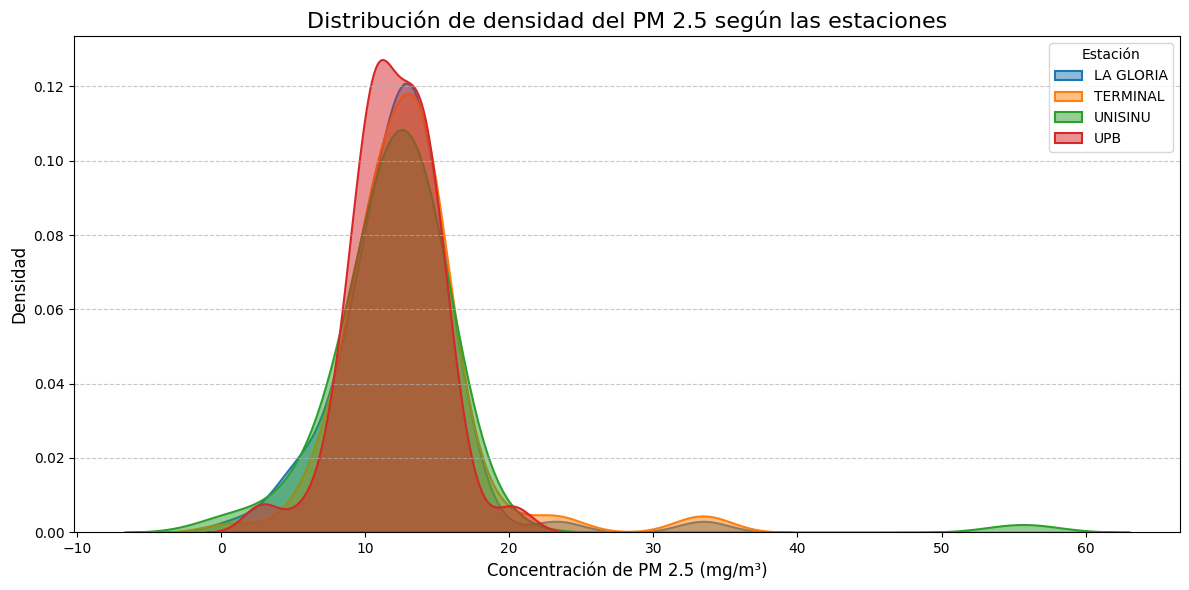

In [97]:
# Filtrar los datos para PM 2.5
pm_25_cleaned = datos_recopilados[datos_recopilados['Parametro'] == 'PM 2.5'].dropna(subset=['Concentración_mg/m3'])

# Confirmar que 'Estacion' sea categórica
pm_25_cleaned['Estacion'] = pm_25_cleaned['Estacion'].astype('category')

# Crear el gráfico de densidad
plt.figure(figsize=(12, 6))

for estacion in pm_25_cleaned['Estacion'].cat.categories:
    subset = pm_25_cleaned[pm_25_cleaned['Estacion'] == estacion]
    sns.kdeplot(
        data=subset,
        x="Concentración_mg/m3",
        label=estacion,
        fill=True,
        alpha=0.5,
        linewidth=1.5
    )

# Configuración del gráfico
plt.title("Distribución de densidad del PM 2.5 según las estaciones", fontsize=16)
plt.xlabel("Concentración de PM 2.5 (mg/m³)", fontsize=12)
plt.ylabel("Densidad", fontsize=12)
plt.legend(title="Estación", loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

:::{admonition} **Grafico de densidad PM 2.5**
:class: tip

El gráfico de densidad muestra la distribución de las concentraciones de PM 2.5 en las diferentes estaciones: **LA GLORIA**, **TERMINAL**, **UNISINU** y **UPB**. En general, las distribuciones tienen características similares con picos pronunciados alrededor de concentraciones entre 10 y 15 mg/m³, lo que sugiere que la mayoría de las mediciones se concentran en este rango.

1. **Estación UPB**: Presenta el pico más alto, lo que indica una mayor densidad de concentraciones en el rango central, lo cual sugiere una menor variabilidad en comparación con las demás estaciones.

2. **Estaciones LA GLORIA, TERMINAL y UNISINU**: Aunque sus distribuciones son similares en forma, muestran ligeras diferencias en la altura y dispersión, reflejando una mayor variabilidad en las concentraciones de PM 2.5.

3. **Extremos**: Las concentraciones más altas (valores fuera del rango principal) son más visibles en **TERMINAL** y **UNISINU**, indicando la posibilidad de eventos puntuales que han incrementado significativamente los niveles de PM 2.5.

En conclusión, el análisis sugiere que la mayoría de las estaciones tienen un comportamiento homogéneo en cuanto a las concentraciones de PM 2.5, con pequeñas diferencias en la densidad y dispersión. La estación **UPB** destaca por su mayor densidad en el rango central, mientras que **TERMINAL** y **UNISINU** muestran una mayor presencia de valores extremos.

:::


* Hagamos las pruebas de normalidad de la variable PM 2.5 y tambien según la estación

In [80]:
# Suponiendo que datos_recopilados está cargado correctamente
# Filtrar los datos para PM 2.5
pm_25 = datos_recopilados[datos_recopilados['Parametro'] == 'PM 2.5']

# Inicializar un diccionario para almacenar resultados
normalidad_resultados_pm25 = {
    'Prueba': [],
    'Estación': [],
    'n': [],
    'Estadístico': [],
    'p-valor': []
}

# Analizar normalidad para cada estación y total
for estacion in pm_25['Estacion'].unique():
    # Filtrar datos por estación
    pm25_estacion = pm_25[pm_25['Estacion'] == estacion]['Concentración_mg/m3'].dropna()

    # Agregar el número de observaciones (n)
    n = len(pm25_estacion)

    # Prueba de Kolmogorov-Smirnov
    ks_result = ks_1samp((pm25_estacion - np.mean(pm25_estacion)) / np.std(pm25_estacion), cdf=norm.cdf)
    normalidad_resultados_pm25['Prueba'].append('Kolmogorov-Smirnov')
    normalidad_resultados_pm25['Estación'].append(estacion)
    normalidad_resultados_pm25['n'].append(n)
    normalidad_resultados_pm25['Estadístico'].append(ks_result.statistic)
    normalidad_resultados_pm25['p-valor'].append(round(ks_result.pvalue, 3))

# Calcular para el total sin descomponer por estación
pm25_total = pm_25['Concentración_mg/m3'].dropna()
n_total = len(pm25_total)

# Prueba de Kolmogorov-Smirnov
ks_total = ks_1samp((pm25_total - np.mean(pm25_total)) / np.std(pm25_total), cdf=norm.cdf)
normalidad_resultados_pm25['Prueba'].append('Kolmogorov-Smirnov')
normalidad_resultados_pm25['Estación'].append('Total (Sin Descomponer)')
normalidad_resultados_pm25['n'].append(n_total)
normalidad_resultados_pm25['Estadístico'].append(ks_total.statistic)
normalidad_resultados_pm25['p-valor'].append(round(ks_total.pvalue, 3))

# Convertir los resultados a un DataFrame
normalidad_resultados_pm25_df = pd.DataFrame(normalidad_resultados_pm25)

# Reordenar columnas para que 'n' aparezca después de 'Estación'
normalidad_resultados_pm25_df = normalidad_resultados_pm25_df[['Estación', 'n', 'Prueba', 'Estadístico', 'p-valor']]

# Mostrar los resultados
normalidad_resultados_pm25_df

,Estación,n,Prueba,Estadístico,p-valor
0,LA GLORIA,78,Kolmogorov-Smirnov,0.128007,0.142
1,TERMINAL,93,Kolmogorov-Smirnov,0.184401,0.003
2,UNISINU,78,Kolmogorov-Smirnov,0.243109,0.000
3,UPB,89,Kolmogorov-Smirnov,0.062678,0.854
4,Total (Sin Descomponer),338,Kolmogorov-Smirnov,0.155052,0.000


:::{admonition} **Análisis de normalidad de las concentraciones de PM 2.5**
:class: tip 

La tabla presenta los resultados de la prueba de Kolmogorov-Smirnov aplicada a las concentraciones de PM 2.5 por estación y para el total general, con el objetivo de evaluar si los datos siguen una distribución normal. En la estación **LA GLORIA**, con 78 observaciones, el estadístico KS fue 0.128 y el p-valor de 0.142, indicando que no se rechaza la hipótesis nula de normalidad, por lo que las concentraciones de PM 2.5 podrían ajustarse razonablemente a una distribución normal. En contraste, la estación **TERMINAL**, con 93 observaciones, presentó un estadístico KS de 0.184 y un p-valor de 0.003, sugiriendo que los datos no siguen una distribución normal. De manera similar, en **UNISINU**, con 78 observaciones, el estadístico KS fue 0.243 y el p-valor de 0.000, lo que indica una fuerte desviación respecto a la normalidad. En la estación **UPB**, con 89 observaciones, el estadístico KS fue 0.063 y el p-valor de 0.854, indicando que los datos pueden aproximarse a una distribución normal. Finalmente, para el total general, que incluye 338 observaciones de todas las estaciones combinadas, el estadístico KS fue 0.155 y el p-valor de 0.000, concluyendo que las concentraciones de PM 2.5 no siguen una distribución normal cuando se analizan en su conjunto.

Estos resultados subrayan que las concentraciones de PM 2.5 presentan comportamientos distintos según la estación. En estaciones como **TERMINAL** y **UNISINU**, donde no se cumple la normalidad, sería apropiado aplicar transformaciones de datos o métodos no paramétricos en los análisis posteriores. Para el total general, el incumplimiento de la normalidad refuerza la importancia de abordar los análisis de manera segmentada por estación, dado que las diferencias entre ellas podrían estar influenciadas por condiciones ambientales o características específicas de cada ubicación.

:::


* Veamos la prueba no paramétrica `Kruskal-Wallis`, para ver si hay diferencia entre las estaciones por el PM 2.5

In [81]:
# Realizar la prueba de Kruskal-Wallis para PM 2.5 según la estación
pm25_kruskal = kruskal(
    *[pm_25[pm_25['Estacion'] == estacion]['Concentración_mg/m3'].dropna()
      for estacion in pm_25['Estacion'].unique()]
)

# Resultados de Kruskal-Wallis
kruskal_resultado_pm25 = {
    'Prueba': 'Kruskal-Wallis',
    'Estadístico': pm25_kruskal.statistic,
    'p-valor': pm25_kruskal.pvalue
}

# Convertir los resultados a un DataFrame para mejor visualización
kruskal_resultado_pm25_df = pd.DataFrame([kruskal_resultado_pm25])

kruskal_resultado_pm25_df

,Prueba,Estadístico,p-valor
0,Kruskal-Wallis,1.553539,0.66997


:::{admonition} **Interpretación de Kruskal-Wallis del PM 2.5**
:class: tip

El resultado de la prueba de Kruskal-Wallis para las concentraciones de PM 2.5 según la estación arroja un estadístico de **1.55** y un p-valor de **0.670**. Dado que el p-valor es considerablemente mayor al nivel de significancia comúnmente utilizado (por ejemplo, 0.05), no se rechaza la hipótesis nula de que las concentraciones de PM 2.5 tienen la misma distribución entre las estaciones. Esto sugiere que no hay evidencia estadísticamente significativa para afirmar que las concentraciones de PM 2.5 difieren entre las estaciones.

En términos prácticos, los resultados indican que las condiciones que afectan las concentraciones de PM 2.5 son comparables en todas las estaciones, al menos en lo que respecta a las distribuciones de los datos disponibles. Sin embargo, se recomienda considerar otros factores ambientales o temporales que puedan influir en estas mediciones para un análisis más detallado.

:::


## **Comparación del PM10 y PM 2.5**

* Hagamos de manera general la comparación entre el PM 10 y PM 2.5

In [15]:
# Asegurarnos de que la columna 'Parametro' y 'Concentración_mg/m3' están disponibles
df_join_pm_10_25 = datos_recopilados[['Parametro', 'Concentración_mg/m3']].dropna()

resumen_parametro = df_join_pm_10_25.groupby('Parametro')['Concentración_mg/m3'].agg(
    n='count',
    media='mean',
    desviacion_estandar='std',
    mediana='median',
    min='min',
    max='max',
    Q1=lambda x: x.quantile(0.25),
    Q3=lambda x: x.quantile(0.75)
).reset_index()

resumen_parametro

,Parametro,n,media,desviacion_estandar,mediana,min,max,Q1,Q3
0,PM 10,1014,39.212630,4.468585,39.360,21.23,53.18,37.138973,42.0475
1,PM 2.5,338,12.419142,4.451899,12.575,0.69,55.66,10.232500,14.3075


:::{admonition} **Análisis descriptivo de las concentraciones de PM 10 y PM 2.5**
:class: tip

La tabla presenta un análisis descriptivo de las concentraciones de **PM 10** y **PM 2.5**, incluyendo estadísticas clave como la media, mediana, desviación estándar, y rangos intercuartílicos, que permiten una comprensión detallada de su comportamiento.

1. **PM 10**
   - **Tamaño de muestra (n):** Se analizaron un total de 1014 observaciones para PM 10.
   - **Promedio y Mediana:** La concentración promedio es de **39.21 mg/m³**, mientras que la mediana es ligeramente superior, con **39.36 mg/m³**, lo que indica una distribución equilibrada y simétrica en general.
   - **Variabilidad:** La desviación estándar es de **4.47 mg/m³**, lo que refleja una dispersión moderada en las mediciones. 
   - **Rangos:** 
     - El valor mínimo registrado es de **21.23 mg/m³**, mientras que el máximo alcanza **53.18 mg/m³**.
     - El 50% de las observaciones están contenidas entre **37.14 mg/m³** (Q1) y **42.05 mg/m³** (Q3), destacando una concentración relativamente estable en este rango intercuartílico.

2. **PM 2.5**
   - **Tamaño de muestra (n):** Se analizaron un total de 338 observaciones para PM 2.5.
   - **Promedio y Mediana:** La concentración promedio es de **12.42 mg/m³**, cercana a la mediana de **12.58 mg/m³**, lo que también indica una distribución relativamente equilibrada.
   - **Variabilidad:** La desviación estándar de **4.45 mg/m³** refleja una variabilidad similar a la observada en PM 10, aunque con valores absolutos más bajos.
   - **Rangos:** 
      - El valor mínimo registrado es de **0.69 mg/m³**, mientras que el máximo alcanza **55.66 mg/m³**, sugiriendo la presencia de algunos valores extremos.
      - El rango intercuartílico está comprendido entre **10.23 mg/m³** (Q1) y **14.31 mg/m³** (Q3), destacando que la mayoría de las observaciones se concentran en este intervalo.

**Conclusiones**

1. **Comparación entre PM 10 y PM 2.5:**
   - Las concentraciones de **PM 10** son significativamente más altas que las de **PM 2.5**, tanto en términos de promedio como de mediana, lo que refleja su mayor prevalencia en el ambiente.
   - Sin embargo, **PM 2.5** muestra un rango más amplio, con valores extremos que podrían indicar episodios específicos de contaminación.

2. **Estabilidad en PM 10:** 
   - La concentración de **PM 10** es más consistente, con una menor dispersión relativa (desviación estándar) y un rango intercuartílico más estrecho, lo que sugiere una mayor estabilidad en sus valores.

3. **Variabilidad en PM 2.5:**
   - Aunque las concentraciones de **PM 2.5** son generalmente más bajas, presentan mayor variabilidad y valores extremos, lo que podría requerir un análisis más profundo de las fuentes y condiciones ambientales específicas que influyen en estas mediciones.

Este análisis es fundamental para diseñar estrategias de mitigación y políticas de control ambiental dirigidas a reducir las concentraciones de partículas contaminantes y proteger la salud pública.

:::

* Grafico de comparacion de densidad entre PM 10 y PM 2.5 desde el 2020 hasta 2023

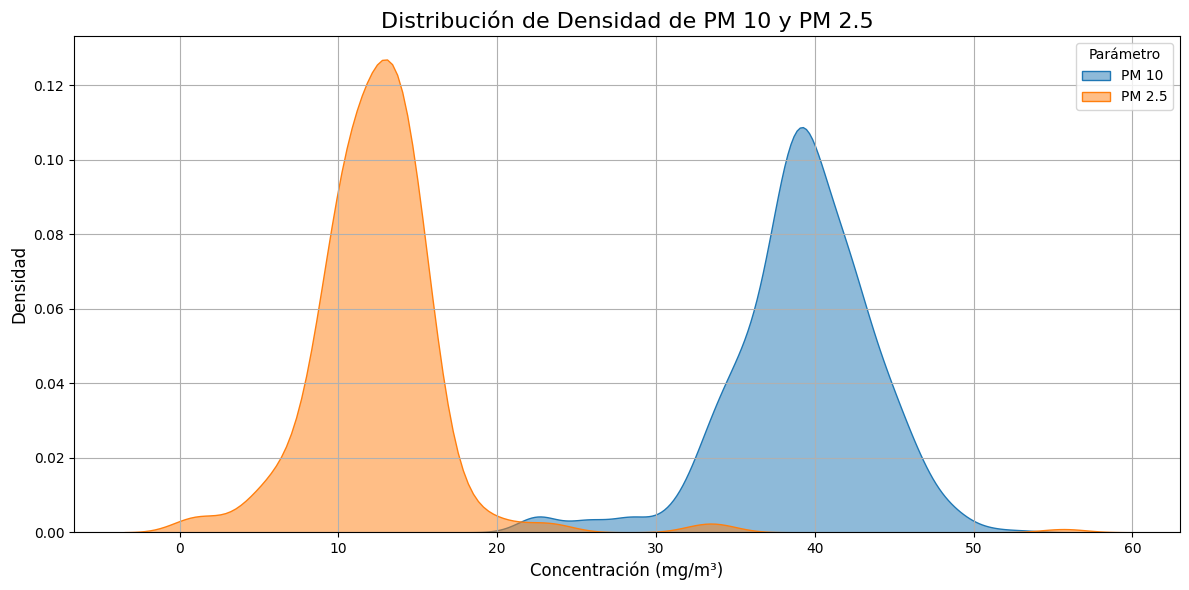

In [18]:
# Gráfico de densidad para PM10 y PM2.5
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df_join_pm_10_25[df_join_pm_10_25['Parametro'] == 'PM 10'], x='Concentración_mg/m3', label='PM 10', fill=True, alpha=0.5)
sns.kdeplot(data=df_join_pm_10_25[df_join_pm_10_25['Parametro'] == 'PM 2.5'], x='Concentración_mg/m3', label='PM 2.5', fill=True, alpha=0.5)
plt.title('Distribución de Densidad de PM 10 y PM 2.5', fontsize=16)
plt.xlabel('Concentración (mg/m³)', fontsize=12)
plt.ylabel('Densidad', fontsize=12)
plt.legend(title='Parámetro', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

:::{admonition} **Interpretación del gráfico de densidad**
:class: tip

El gráfico de densidad muestra las distribuciones de las concentraciones de **PM 10** y **PM 2.5**, destacando sus diferencias en términos de comportamiento. Para **PM 10**, la concentración predominante está en torno a **39 mg/m³**, con una distribución simétrica y menor dispersión, lo que refleja estabilidad en las mediciones. En contraste, la distribución de **PM 2.5** tiene su pico alrededor de **12 mg/m³**, mostrando una mayor asimetría hacia la derecha y la presencia de valores extremos que pueden estar asociados con eventos específicos de contaminación. Al comparar ambos parámetros, **PM 10** presenta concentraciones más altas y consistentes, mientras que **PM 2.5**, al ser más fino, exhibe mayor variabilidad y tendencia a valores extremos. Estos hallazgos resaltan la necesidad de enfoques diferenciados en el monitoreo y mitigación de cada tipo de partícula, considerando sus fuentes y posibles impactos ambientales y de salud pública.

:::


* Veamos un diagrama de cajas y bigotes de la comparacion de PM 10 y PM 2.5 del 2020-2023

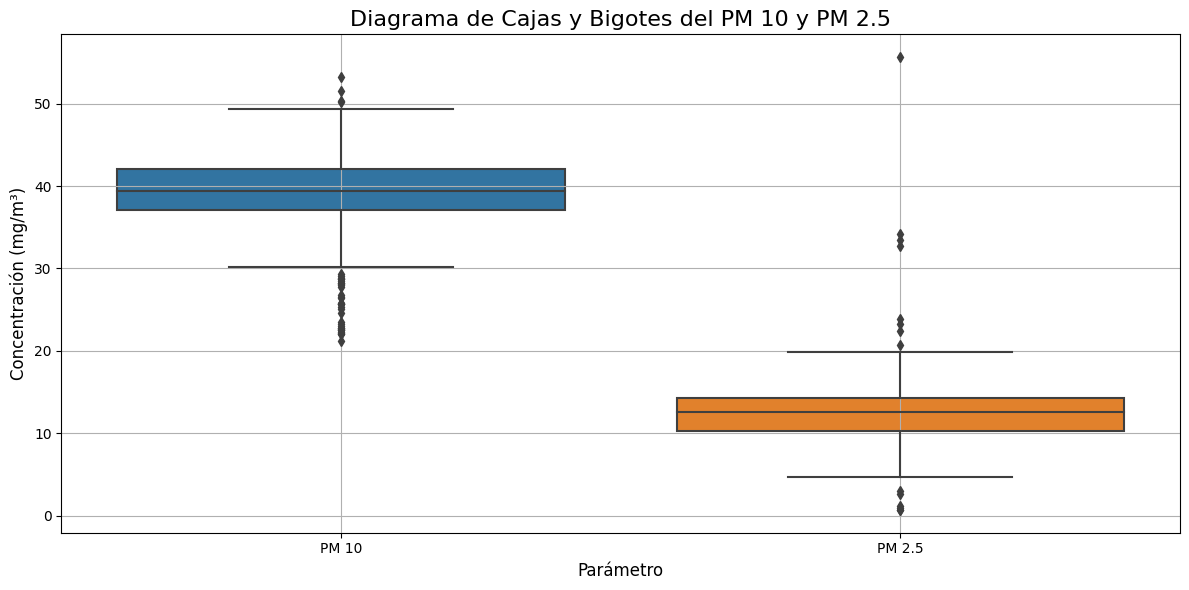

In [17]:
# Gráfico de cajas y bigotes
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_join_pm_10_25, x='Parametro', y='Concentración_mg/m3')
plt.title('Diagrama de Cajas y Bigotes del PM 10 y PM 2.5', fontsize=16)
plt.xlabel('Parámetro', fontsize=12)
plt.ylabel('Concentración (mg/m³)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

:::{admonition} **Interpretación del diagrama de cajas y bigotes**
:class: tip

El diagrama de cajas y bigotes ilustra la distribución de las concentraciones de **PM 10** y **PM 2.5**, mostrando diferencias clave en su rango, variabilidad y presencia de valores atípicos.

Para **PM 10**, los valores se concentran entre aproximadamente **37 mg/m³** (Q1) y **42 mg/m³** (Q3), con una mediana en torno a **39 mg/m³**, lo que indica una distribución relativamente simétrica. Sin embargo, se observan valores atípicos por debajo de **30 mg/m³** y por encima de **50 mg/m³**, lo que refleja variaciones ocasionales significativas.

Por otro lado, **PM 2.5** muestra un rango más amplio de concentración, desde aproximadamente **10 mg/m³** (Q1) hasta **14 mg/m³** (Q3), con una mediana cercana a **12 mg/m³**. La presencia de valores atípicos por encima de **30 mg/m³** destaca eventos puntuales de altas concentraciones, posiblemente asociados con episodios específicos de contaminación.

La comparación entre ambos parámetros evidencia que **PM 10** presenta concentraciones más altas y una distribución más estable, mientras que **PM 2.5** muestra mayor variabilidad relativa, resaltando su susceptibilidad a variaciones ambientales. Estas características son críticas para diseñar estrategias de control específicas para cada tipo de material particulado.

:::


* Probemos la homocedasticidad 

In [32]:
# Extraer los datos de concentración
pm10_values = datos_recopilados[datos_recopilados['Parametro'] == 'PM 10']['Concentración_mg/m3']
pm25_values = datos_recopilados[datos_recopilados['Parametro'] == 'PM 2.5']['Concentración_mg/m3']

# Realizar la prueba de Mann-Whitney U
mann_whitney_result = mannwhitneyu(
    pm10_values,
    pm25_values,
    alternative='two-sided'
)

# Crear un DataFrame con los resultados
resultado_mann_whitney = pd.DataFrame([{
    'Prueba': 'Mann-Whitney U',
    'Estadístico': mann_whitney_result.statistic,
    'p-valor': round(mann_whitney_result.pvalue, 5)
}])

# Mostrar resultados
resultado_mann_whitney


,Prueba,Estadístico,p-valor
0,Mann-Whitney U,341443.5,0.0


:::{admonition} **Comparación entre PM 10 y PM 2.5: Prueba de Mann-Whitney U**
:class: tip 

La prueba de Mann-Whitney U fue aplicada para comparar las concentraciones de PM 10 y PM 2.5 desde el año 2020 hasta 2023. Los resultados muestran un estadístico de **341,443.5** y un **p-valor de 0.0**, indicando una diferencia estadísticamente significativa entre las distribuciones de los dos parámetros. Esto implica que las concentraciones de PM 10 y PM 2.5 tienen comportamientos notablemente diferentes en términos de su distribución. Este resultado resalta la necesidad de analizar ambos parámetros de forma separada en estudios relacionados con calidad del aire, ya que no pueden considerarse estadísticamente equivalentes.

:::


* Análicemos la correlación del PM 10 y PM 2.5 desde 2020 al 2023

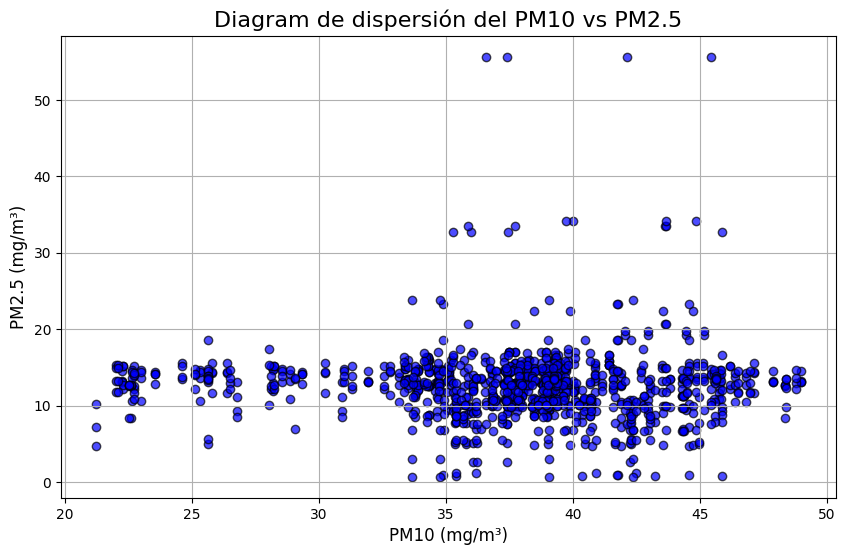

In [24]:
# Suponiendo que 'df_original' es el dataset principal que contiene datos de PM10 y PM2.5
df_pm10 = datos_recopilados[datos_recopilados['Parametro'] == 'PM 10'][['Fecha', 'Concentración_mg/m3']]
df_pm25 = datos_recopilados[datos_recopilados['Parametro'] == 'PM 2.5'][['Fecha', 'Concentración_mg/m3']]

# Convert 'Fecha' to datetime for both DataFrames
df_pm10['Fecha'] = pd.to_datetime(df_pm10['Fecha'])
df_pm25['Fecha'] = pd.to_datetime(df_pm25['Fecha'])

# Merge the two datasets based on the 'Fecha' column
df_merged = pd.merge(
    df_pm10[['Fecha', 'Concentración_mg/m3']].rename(columns={'Concentración_mg/m3': 'PM10'}),
    df_pm25[['Fecha', 'Concentración_mg/m3']].rename(columns={'Concentración_mg/m3': 'PM2.5'}),
    on='Fecha'
)

# Plot the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df_merged['PM10'], df_merged['PM2.5'], alpha=0.7, c='b', edgecolors='k')
plt.title('Diagram de dispersión del PM10 vs PM2.5', fontsize=16)
plt.xlabel('PM10 (mg/m³)', fontsize=12)
plt.ylabel('PM2.5 (mg/m³)', fontsize=12)
plt.grid(True)
plt.show()


In [23]:
# Combinar los DataFrames asegurándonos de que las fechas coincidan
df_combined = pd.merge(df_pm10, df_pm25, on='Fecha', suffixes=('_PM10', '_PM25'))

# Realizar la prueba de Spearman
spearman_corr, p_value = spearmanr(
    df_combined['Concentración_mg/m3_PM10'], 
    df_combined['Concentración_mg/m3_PM25']
)

# Crear un DataFrame para los resultados
spearman_resultado = {
    'Prueba': ['Spearman'],
    'Estadístico': [spearman_corr],
    'p-valor': [p_value]
}
spearman_resultado_df = pd.DataFrame(spearman_resultado)

# Mostrar el DataFrame
spearman_resultado_df

,Prueba,Estadístico,p-valor
0,Spearman,-0.083155,0.005278


:::{admonition} **Interpretación de la correlación**
:class: tip

La prueba de correlación de Spearman realizada para las concentraciones de **PM 10** y **PM 2.5**, considerando datos desde el año **2020 hasta 2023**, arrojó un coeficiente de correlación (**Estadístico**) de **-0.083** y un **p-valor** de **0.005**.

Esto indica que existe una correlación negativa muy débil entre las concentraciones de **PM 10** y **PM 2.5**. Aunque la relación es estadísticamente significativa debido al bajo p-valor (menor a 0.05), la magnitud del coeficiente sugiere que esta relación tiene poca relevancia práctica. Es decir, los cambios en las concentraciones de **PM 10** no están estrechamente relacionados con los cambios en las concentraciones de **PM 2.5** durante el período analizado.

Estos resultados resaltan la necesidad de analizar las posibles diferencias en las fuentes o factores que afectan la variación de cada tipo de partícula, así como de considerar otros factores ambientales o estacionales que puedan influir en las concentraciones de estos contaminantes.

:::

## **Análisis de correlación de los parámetros climaticos y ambientales**

### **Unión de los datos PM 10 y PM 2.5 con las fechas completas**

* Unión los dataframe creados

In [44]:
# Supongamos que los DataFrames
df_unido = pd.concat([df_res_pm10, df_res_pm_2_5], ignore_index=True)

# Mostrar información del DataFrame unido
df_unido.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9656 entries, 0 to 9655
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Fecha                9656 non-null   datetime64[ns]
 1   Estacion             9656 non-null   object        
 2   Parametro            9656 non-null   object        
 3   Concentración_mg/m3  1350 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 301.9+ KB


* Hagamos un join entre `df_unido` y `datos_parametros` con las fechas completas

In [45]:
# Unir los DataFrames por la columna "Fecha" usando un merge (right join para mantener todos los datos de df_recopilacion)
df_comp = pd.merge(datos_parametros, df_unido, on='Fecha', how='right')
df_comp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34424 entries, 0 to 34423
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Fecha                  34424 non-null  datetime64[ns]
 1   Valor                  34064 non-null  float64       
 2   Unidad                 34064 non-null  object        
 3   Parametros_climaticos  34064 non-null  object        
 4   Estacion               34424 non-null  object        
 5   Parametro              34424 non-null  object        
 6   Concentración_mg/m3    4947 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 1.8+ MB


* Grafica de valores faltantes de los datos `df_comp` 

<Axes: >

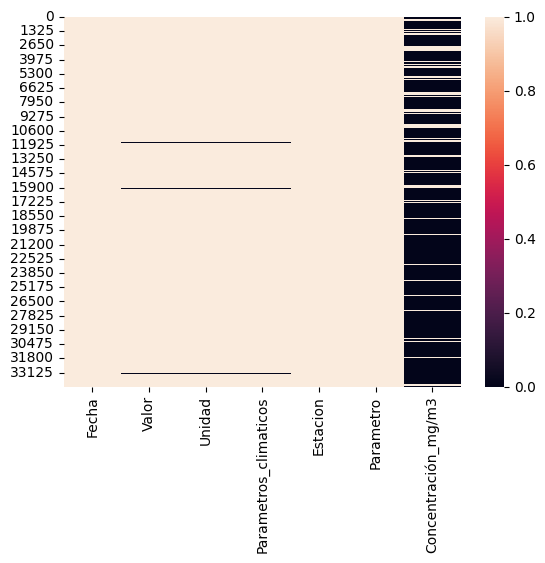

In [78]:
sns.heatmap(df_comp.notna())

In [48]:
df_comp.to_csv('_data/df.csv', index=False)

### **Correlación de variables climáticas y PM 10**

In [56]:
# Reconstruir el conjunto de datos combinado para calcular la correlación de Spearman
pivot_data = df_comp.pivot_table(
    index=["Fecha", "Estacion"],  
    columns="Parametros_climaticos",  
    values="Valor",  
    aggfunc="mean"  
).reset_index()

# Agregar las concentraciones de PM10 al conjunto de datos
pm10_data = df_comp.groupby(["Fecha", "Estacion"])["Concentración_mg/m3"].mean().reset_index()  
merged_data = pd.merge(pivot_data, pm10_data, on=["Fecha", "Estacion"], how="inner")  
merged_data.rename(columns={"Concentración_mg/m3": "PM10"}, inplace=True)  

# Eliminar valores NaN para garantizar datos válidos para la correlación
cleaned_data = merged_data.dropna()

# Calcular la correlación de Spearman y los valores p para PM10 frente a otros parámetros climáticos
spearman_results = []
for column in cleaned_data.columns[2:-1]:  # Excluir columnas no numéricas y la columna de PM10
    if column != "PM10":
        # Calcular el coeficiente de correlación de Spearman y su valor p
        corr, p_value = spearmanr(cleaned_data["PM10"], cleaned_data[column])
        spearman_results.append({"Parametro climaticos": column, "Correlación Spearman": corr, "P-Valor": p_value})

# Convertir los resultados en un DataFrame
spearman_df = pd.DataFrame(spearman_results).sort_values(by="Correlación Spearman", ascending=False)

spearman_df 


,Parametro climaticos,Correlación Spearman,P-Valor
1,Humedad,0.149296,0.003240
3,Temp. Mínima,0.045260,0.374572
0,Dirección Viento,0.031627,0.535042
2,Temp. Maxima,-0.008517,0.867354
4,Velocidad Viento,-0.095269,0.061158


:::{admonition} **Interpretación de las variables climaticas vs PM 10**
:class: tip 

En este análisis estamos usando la fecha del 2020 al 2023 y se utilizó el coeficiente de correlación de Spearman para evaluar la relación entre los niveles de PM10 y los parámetros climáticos registrados. Los resultados obtenidos son los siguientes:

1. **Humedad** mostró una correlación positiva moderada (*ρ* = 0.149, *p* = 0.003), indicando que niveles más altos de humedad están asociados con incrementos en los niveles de PM10. Aunque esta relación es estadísticamente significativa (*p* < 0.05), su magnitud es baja.
   
2. **Temperatura mínima** presentó una correlación débil positiva (*ρ* = 0.045, *p* = 0.375), mientras que la **temperatura máxima** tuvo una correlación débil negativa (*ρ* = -0.009, *p* = 0.867). En ambos casos, los valores *p* sugieren que estas correlaciones no son estadísticamente significativas.

3. **Dirección del viento** tuvo una correlación muy débil positiva (*ρ* = 0.032, *p* = 0.535), indicando que este parámetro no tiene una relación significativa con los niveles de PM10.

4. **Velocidad del viento** mostró una correlación negativa débil (*ρ* = -0.095, *p* = 0.061). Aunque no es estadísticamente significativa al nivel convencional (*p* < 0.05), este parámetro podría estar asociado con una ligera reducción de los niveles de PM10.

En conclusión, entre los parámetros climáticos analizados, **la humedad** es el único que muestra una relación significativa con los niveles de PM10, aunque la magnitud de la correlación es limitada. Estos hallazgos resaltan la necesidad de un análisis más profundo y multidimensional que incorpore otros factores no climáticos que puedan influir en los niveles de PM10, especialmente en entornos donde la calidad del aire es crítica para la salud pública.

:::


### **Correlación de variables climáticas vs PM 10 según la estación**

In [57]:
# Calcular la correlación de Spearman entre PM10 y los parámetros climáticos agrupados por "Estacion"
station_results = []

# Agrupar por estación y calcular las correlaciones
for station, station_data in cleaned_data.groupby("Estacion"):
    spearman_station = []
    for column in station_data.columns[2:-1]:  # Excluir columnas no numéricas y la columna PM10
        if column != "PM10":
            # Calcular la correlación de Spearman y el valor p
            corr, p_value = spearmanr(station_data["PM10"], station_data[column])
            spearman_station.append({"Estacion": station, "Parametros climaticos": column, "Correlación Spearman": corr, "P-Valor": p_value})
    # Agregar los resultados de la estación actual a la lista general
    station_results.extend(spearman_station)

# Convertir los resultados en un DataFrame
station_corr_df = pd.DataFrame(station_results)

station_corr_df


,Estacion,Parametros climaticos,Correlación Spearman,P-Valor
0,LA GLORIA,Dirección Viento,-0.003347,0.973904
1,LA GLORIA,Humedad,0.202014,0.046066
2,LA GLORIA,Temp. Maxima,-0.014161,0.889930
3,LA GLORIA,Temp. Mínima,-0.011993,0.906699
4,LA GLORIA,Velocidad Viento,-0.021059,0.836927
5,TERMINAL,Dirección Viento,0.128187,0.213255
6,TERMINAL,Humedad,0.130171,0.206198
7,TERMINAL,Temp. Maxima,0.014532,0.888244
8,TERMINAL,Temp. Mínima,0.038029,0.712982
9,TERMINAL,Velocidad Viento,-0.201767,0.048686


:::{admonition} **Interpretación de las variables climaticas vs PM 10 por estación**
:class: tip  Conclusión

En este análisis se evaluaron las correlaciones de Spearman entre las concentraciones de PM10 y diversos parámetros climáticos (dirección del viento, humedad, temperatura máxima, temperatura mínima y velocidad del viento) para diferentes estaciones de monitoreo: **LA GLORIA**, **TERMINAL**, **UNISINU** y **UPB**. COn fecha de 2020 hasta 2023, los resultados obtenidos permiten destacar los siguientes hallazgos:

1. **Estación LA GLORIA**:
   - La humedad presentó una correlación positiva débil (*ρ* = 0.202, *p* = 0.046), siendo estadísticamente significativa (*p* < 0.05).
   - Los demás parámetros climáticos no mostraron relaciones significativas con PM10, con valores de *p* > 0.05.

2. **Estación TERMINAL**:
   - La velocidad del viento tuvo una correlación negativa débil (*ρ* = -0.202, *p* = 0.049), significativa al nivel de *p* < 0.05.
   - Los otros parámetros climáticos no presentaron correlaciones significativas.

3. **Estación UNISINU**:
   - Ningún parámetro climático presentó una correlación estadísticamente significativa con PM10 (*p* > 0.05), aunque la humedad mostró una correlación positiva débil (*ρ* = 0.182, *p* = 0.077).

4. **Estación UPB**:
   - Ningún parámetro climático presentó una correlación significativa (*p* > 0.05), y todas las correlaciones fueron muy débiles.

**Interpretación**

Entre los resultados, se destacan las correlaciones significativas observadas en **LA GLORIA** (humedad) y **TERMINAL** (velocidad del viento), aunque su magnitud es débil, lo que sugiere que estas variables pueden tener una influencia limitada sobre los niveles de PM10. En las demás estaciones, las relaciones entre los parámetros climáticos y PM10 no fueron significativas.

Estos hallazgos indican que los factores climáticos considerados podrían no ser los principales determinantes de las concentraciones de PM10 en estas estaciones. Esto resalta la necesidad de investigar otras variables, como fuentes de emisión específicas, patrones de tráfico, o actividad industrial, para comprender mejor las fluctuaciones en los niveles de PM10 y diseñar estrategias efectivas para la mejora de la calidad del aire.

:::


### **Correlación de variables climáticas y PM 2.5**

In [58]:
# Agregar las concentraciones de PM2.5 al conjunto de datos
pm25_data = df_comp.groupby(["Fecha", "Estacion"])["Concentración_mg/m3"].mean().reset_index()  # Promedio por Fecha y Estación
merged_data = pd.merge(pivot_data, pm25_data, on=["Fecha", "Estacion"], how="inner")  # Combinar los datos pivotados con las concentraciones de PM2.5
merged_data.rename(columns={"Concentración_mg/m3": "PM2.5"}, inplace=True)  # Renombrar la columna de PM2.5 para mayor claridad

# Eliminar valores NaN para garantizar datos válidos para la correlación
cleaned_data = merged_data.dropna()

# Calcular la correlación de Spearman y los valores p para PM2.5 frente a otros parámetros climáticos
spearman_results = []
for column in cleaned_data.columns[2:-1]:  # Excluir columnas no numéricas y la columna de PM2.5
    if column != "PM2.5":
        # Calcular el coeficiente de correlación de Spearman y su valor p
        corr, p_value = spearmanr(cleaned_data["PM2.5"], cleaned_data[column])
        spearman_results.append({"Parametros climaticos": column, "Correlación Spearman": corr, "P-Valor": p_value})

# Convertir los resultados en un DataFrame
spearman_df = pd.DataFrame(spearman_results).sort_values(by="Correlación Spearman", ascending=False)

spearman_df  


,Parametros climaticos,Correlación Spearman,P-Valor
1,Humedad,0.149296,0.003240
3,Temp. Mínima,0.045260,0.374572
0,Dirección Viento,0.031627,0.535042
2,Temp. Maxima,-0.008517,0.867354
4,Velocidad Viento,-0.095269,0.061158


:::{admonition} **Interpretación de las variables climaticas vs PM 2.5**
:class: tip 

En este análisis, se evaluaron las correlaciones de Spearman entre las concentraciones de PM2.5 y varios parámetros climáticos. Los resultados obtenidos indican las siguientes relaciones:

1. **Humedad**:
   - Presentó una correlación positiva moderada (*ρ* = 0.149, *p* = 0.003), siendo estadísticamente significativa (*p* < 0.05). Esto sugiere que niveles más altos de humedad podrían estar relacionados con un aumento en las concentraciones de PM2.5.

2. **Temperatura mínima**:
   - La correlación fue positiva débil (*ρ* = 0.045, *p* = 0.375), pero no estadísticamente significativa, lo que indica una relación débil y posiblemente no consistente.

3. **Dirección del viento**:
   - Mostró una correlación muy débil positiva (*ρ* = 0.032, *p* = 0.535), sin significancia estadística (*p* > 0.05). Esto sugiere que la dirección del viento tiene una influencia mínima en las concentraciones de PM2.5.

4. **Temperatura máxima**:
   - La correlación fue débil y negativa (*ρ* = -0.009, *p* = 0.867), no siendo significativa. Esto implica que no hay una relación clara entre la temperatura máxima y los niveles de PM2.5.

5. **Velocidad del viento**:
   - Tuvo una correlación negativa débil (*ρ* = -0.095, *p* = 0.061), que tampoco fue estadísticamente significativa. Aunque la relación es tenue, podría indicar que velocidades más altas del viento están ligeramente asociadas con una reducción de PM2.5.

**Interpretación**

Entre los parámetros analizados, **la humedad** es el único que muestra una correlación estadísticamente significativa con las concentraciones de PM2.5, aunque su magnitud es limitada. Los demás parámetros no presentan relaciones significativas ni patrones claros.

Estos resultados sugieren que, si bien algunos factores climáticos pueden influir en las concentraciones de PM2.5, su impacto parece ser limitado. Esto resalta la necesidad de considerar otras variables, como fuentes de emisión, características geográficas y actividades humanas, para comprender plenamente los patrones de variación de PM2.5 y diseñar estrategias efectivas para mejorar la calidad del aire.

:::


### **Correlación de variables climáticas vs PM 2.5 según la estación**

In [59]:
# Calcular la correlación de Spearman entre PM2.5 y los parámetros climáticos agrupados por "Estacion"
station_results = []

# Agrupar por estación y calcular las correlaciones
for station, station_data in cleaned_data.groupby("Estacion"):
    spearman_station = []
    for column in station_data.columns[2:-1]:  # Excluir columnas no numéricas y la columna PM2.5
        if column != "PM2.5":
            # Calcular la correlación de Spearman y el valor p
            corr, p_value = spearmanr(station_data["PM2.5"], station_data[column])
            spearman_station.append({"Estacion": station, "Parametros climaticos": column, "Correlación Spearman": corr, "P-Valor": p_value})
    # Agregar los resultados de la estación actual a la lista general
    station_results.extend(spearman_station)

# Convertir los resultados en un DataFrame
station_corr_df = pd.DataFrame(station_results)

station_corr_df  # Mostrar el DataFrame con los resultados


,Estacion,Parametros climaticos,Correlación Spearman,P-Valor
0,LA GLORIA,Dirección Viento,-0.003347,0.973904
1,LA GLORIA,Humedad,0.202014,0.046066
2,LA GLORIA,Temp. Maxima,-0.014161,0.889930
3,LA GLORIA,Temp. Mínima,-0.011993,0.906699
4,LA GLORIA,Velocidad Viento,-0.021059,0.836927
5,TERMINAL,Dirección Viento,0.128187,0.213255
6,TERMINAL,Humedad,0.130171,0.206198
7,TERMINAL,Temp. Maxima,0.014532,0.888244
8,TERMINAL,Temp. Mínima,0.038029,0.712982
9,TERMINAL,Velocidad Viento,-0.201767,0.048686


:::{admonition} **Interpretación de las variables climaticas vs PM 10 por estación**
:class: tip 

En este análisis se evaluaron las correlaciones de Spearman entre las concentraciones de PM2.5 y diversos parámetros climáticos agrupados por estación de monitoreo (**LA GLORIA**, **TERMINAL**, **UNISINU** y **UPB**). A continuación, se presentan los hallazgos clave:

1. **Estación LA GLORIA**:
   - La **humedad** mostró una correlación positiva moderada (*ρ* = 0.202, *p* = 0.046), siendo estadísticamente significativa (*p* < 0.05). Esto sugiere que niveles más altos de humedad pueden estar asociados con mayores concentraciones de PM2.5.
   - Los demás parámetros no presentaron correlaciones significativas con PM2.5 (*p* > 0.05).

2. **Estación TERMINAL**:
   - La **velocidad del viento** tuvo una correlación negativa débil (*ρ* = -0.202, *p* = 0.049), significativa al nivel de *p* < 0.05. Esto sugiere que velocidades más altas del viento podrían reducir las concentraciones de PM2.5.
   - Ningún otro parámetro mostró relaciones significativas con PM2.5.

3. **Estación UNISINU**:
   - Aunque ningún parámetro alcanzó significancia estadística (*p* > 0.05), la **humedad** presentó una correlación positiva débil (*ρ* = 0.182, *p* = 0.077), lo que podría indicar una tendencia leve.

4. **Estación UPB**:
   - Ninguno de los parámetros climáticos mostró correlaciones significativas con PM2.5 (*p* > 0.05). Las relaciones fueron débiles y sin relevancia estadística.

**Interpretación**

Entre los parámetros evaluados, **la humedad** en la estación **LA GLORIA** y la **velocidad del viento** en la estación **TERMINAL** mostraron correlaciones significativas con PM2.5, aunque la magnitud de estas relaciones es débil. En las demás estaciones, las correlaciones fueron no significativas y de baja magnitud, lo que sugiere que los factores climáticos analizados podrían no ser los principales determinantes de las concentraciones de PM2.5.

Estos resultados destacan la necesidad de considerar otras variables, como fuentes de emisión específicas, características geográficas y patrones de actividad humana, para entender completamente las variaciones de PM2.5 y formular estrategias eficaces para la mejora de la calidad del aire.

:::
